Import Library

In [13]:
# ETCXGB Feature Selection - Heart Disease Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("🚀 ETCXGB Feature Selection - Heart Disease Analysis")
print("=" * 55)

🚀 ETCXGB Feature Selection - Heart Disease Analysis


In [14]:
# 📊 DATA LOADING & DUPLICATE ANALYSIS
df_original = pd.read_csv('dataset.csv')
duplicates = df_original.duplicated().sum()
duplicate_pct = (duplicates / len(df_original)) * 100

print(f"Dataset original: {df_original.shape[0]} baris, duplikasi: {duplicates} ({duplicate_pct:.1f}%)")

if duplicate_pct > 50:
    print(f"⚠️  Duplikasi tinggi ({duplicate_pct:.1f}%) - menggunakan dataset yang diperbaiki")
    df = pd.read_csv('dataset_fully_unique.csv')
    print(f"Dataset diperbaiki: {df.shape[0]} baris, duplikasi: {df.duplicated().sum()}")
else:
    df = df_original

X = df.drop('target', axis=1)
y = df['target']
print(f"✅ Siap analisis: {len(df)} sampel, {len(X.columns)} fitur")

Dataset original: 1025 baris, duplikasi: 723 (70.5%)
⚠️  Duplikasi tinggi (70.5%) - menggunakan dataset yang diperbaiki
Dataset diperbaiki: 1025 baris, duplikasi: 0
✅ Siap analisis: 1025 sampel, 13 fitur


In [15]:
# 🔧 FEATURE CATEGORIZATION
numerik_kontinyu = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
numerik_diskrit = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print(f"Numerik kontinyu: {len(numerik_kontinyu)} fitur - {numerik_kontinyu}")
print(f"Numerik diskrit:  {len(numerik_diskrit)} fitur - {numerik_diskrit}")

Numerik kontinyu: 5 fitur - ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Numerik diskrit:  8 fitur - ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [16]:
# 🎯 FEATURE SELECTION METHODS
def pcc_selection(X, y, threshold=0.2):
    """PCC untuk fitur numerik kontinyu"""
    selected = []
    for feature in numerik_kontinyu:
        if feature in X.columns:
            corr = abs(X[feature].corr(y))
            if corr >= threshold:
                selected.append(feature)
    return selected

def chi2_selection(X, y, k=4):
    """Chi-Square untuk fitur numerik diskrit"""
    diskrit_X = X[numerik_diskrit]
    selector = SelectKBest(chi2, k=min(k, len(numerik_diskrit)))
    selector.fit(diskrit_X, y)
    selected_indices = selector.get_support(indices=True)
    return [numerik_diskrit[i] for i in selected_indices]

print("✅ Feature selection methods ready")

✅ Feature selection methods ready


In [ ]:
# 🤖 ETCXGB HYBRID MODEL CONFIGURATION - MULTIPLE SCENARIOS
# =============================================================
# 📝 UBAH PARAMETER ARRAYS DI SINI UNTUK MULTIPLE SKENARIO:
ETC_STAGE1_ESTIMATORS_LIST = [100, 150, 200]        # Array jumlah estimators untuk ETC stage 1
ETC_STAGE2_ESTIMATORS_LIST = [150, 200, 250]        # Array jumlah estimators untuk ETC stage 2
RANDOM_STATE_LIST = [42, 123, 456]                  # Array random state untuk reproducibility
PCC_THRESHOLD_LIST = [0.1, 0.15, 0.2, 0.25]       # Array threshold untuk PCC selection
CHI2_K_LIST = [3, 4, 5, 6]                         # Array jumlah fitur terbaik untuk Chi2 selection

print("🤖 PARAMETER ARRAYS KONFIGURASI:")
print(f"   ETC Stage 1 Estimators: {ETC_STAGE1_ESTIMATORS_LIST}")
print(f"   ETC Stage 2 Estimators: {ETC_STAGE2_ESTIMATORS_LIST}")
print(f"   Random States: {RANDOM_STATE_LIST}")
print(f"   PCC Thresholds: {PCC_THRESHOLD_LIST}")
print(f"   Chi2 K values: {CHI2_K_LIST}")
print("=" * 60)

class ETCXGBHybrid:
    def __init__(self, stage1_estimators=150, stage2_estimators=200, random_state=42):
        self.etc = ExtraTreesClassifier(n_estimators=stage1_estimators, random_state=random_state)
        self.final_etc = ExtraTreesClassifier(n_estimators=stage2_estimators, random_state=random_state)
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        self.etc.fit(X_scaled, y)
        etc_pred = self.etc.predict(X_scaled).reshape(-1, 1)
        X_combined = np.hstack((X_scaled, etc_pred))
        self.final_etc.fit(X_combined, y)
        return self
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        etc_pred = self.etc.predict(X_scaled).reshape(-1, 1)
        X_combined = np.hstack((X_scaled, etc_pred))
        return self.final_etc.predict(X_combined)

print("✅ ETCXGB model ready with configurable parameters")

🤖 PARAMETER ARRAYS KONFIGURASI:
   ETC Stage 1 Estimators: [100, 150]
   ETC Stage 2 Estimators: [150, 200]
   Random States: [42, 123]
   PCC Thresholds: [0.15, 0.2]
   Chi2 K values: [4, 5]
✅ ETCXGB model ready with configurable parameters


In [29]:
# 🎯 MULTIPLE SCENARIOS PARAMETER CONFIGURATION & EVALUATION
# ===========================================================

from itertools import product
import time

print("🎯 GENERATING MULTIPLE PARAMETER SCENARIOS...")
print("=" * 60)

# Generate all combinations of parameters
parameter_combinations = list(product(
    ETC_STAGE1_ESTIMATORS_LIST,
    ETC_STAGE2_ESTIMATORS_LIST, 
    RANDOM_STATE_LIST,
    PCC_THRESHOLD_LIST,
    CHI2_K_LIST
))

total_combinations = len(parameter_combinations)
print(f"📊 TOTAL PARAMETER COMBINATIONS: {total_combinations}")
print(f"   ETC Stage 1: {len(ETC_STAGE1_ESTIMATORS_LIST)} values")
print(f"   ETC Stage 2: {len(ETC_STAGE2_ESTIMATORS_LIST)} values") 
print(f"   Random State: {len(RANDOM_STATE_LIST)} values")
print(f"   PCC Threshold: {len(PCC_THRESHOLD_LIST)} values")
print(f"   Chi2 K: {len(CHI2_K_LIST)} values")
print("=" * 60)

# Estimate total evaluation time
estimated_time_per_combo = 10  # seconds per combination (rough estimate)
estimated_total_time = total_combinations * estimated_time_per_combo
print(f"⏱️  ESTIMATED TOTAL TIME: ~{estimated_total_time/60:.1f} minutes")
print(f"⚠️  This will run {total_combinations} different parameter combinations!")

# Ask user confirmation for large number of combinations
if total_combinations > 50:
    print(f"\n⚠️  WARNING: {total_combinations} combinations is quite large!")
    print("💡 Consider reducing parameter arrays for faster execution")
    print("=" * 60)

print("\n🔍 STARTING COMPREHENSIVE EVALUATION...")
print("=" * 60)

# 🧪 COMPREHENSIVE EVALUATION - MULTIPLE PARAMETER SCENARIOS
print(f"\n🧪 Evaluating all parameter combinations...")

def calculate_specificity(y_true, y_pred):
    """Calculate specificity (True Negative Rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def evaluate_scenario_with_params(features, scenario_name, stage1_est, stage2_est, rand_state, pcc_thresh, chi2_k):
    """Evaluate scenario dengan parameter spesifik"""
    X_selected = X[features]
    
    # Metrics storage
    cv_metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 
        'specificity': [], 'f1': []
    }
    
    # Confusion matrix storage
    total_cm = np.zeros((2, 2))
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)
    
    for train_idx, test_idx in skf.split(X_selected, y):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Create model with specific parameters
        model = ETCXGBHybrid(
            stage1_estimators=stage1_est,
            stage2_estimators=stage2_est, 
            random_state=rand_state
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        cv_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        cv_metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        cv_metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        cv_metrics['specificity'].append(calculate_specificity(y_test, y_pred))
        cv_metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        
        # Accumulate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        total_cm += cm
    
    return {
        'Scenario': scenario_name,
        'Features': len(features),
        'Stage1_Estimators': stage1_est,
        'Stage2_Estimators': stage2_est,
        'Random_State': rand_state,
        'PCC_Threshold': pcc_thresh,
        'Chi2_K': chi2_k,
        'Accuracy_Mean': np.mean(cv_metrics['accuracy']),
        'Accuracy_Std': np.std(cv_metrics['accuracy']),
        'Precision_Mean': np.mean(cv_metrics['precision']),
        'Precision_Std': np.std(cv_metrics['precision']),
        'Recall_Mean': np.mean(cv_metrics['recall']),
        'Recall_Std': np.std(cv_metrics['recall']),
        'Specificity_Mean': np.mean(cv_metrics['specificity']),
        'Specificity_Std': np.std(cv_metrics['specificity']),
        'F1_Mean': np.mean(cv_metrics['f1']),
        'F1_Std': np.std(cv_metrics['f1']),
        'Confusion_Matrix': total_cm.astype(int)
    }

# Initialize results storage
all_results = []
combo_count = 0

# Start time tracking
start_time = time.time()

# Run evaluation for each parameter combination
for stage1_est, stage2_est, rand_state, pcc_thresh, chi2_k in parameter_combinations:
    combo_count += 1
    
    print(f"\n🔄 COMBINATION {combo_count}/{total_combinations}")
    print(f"   Stage1: {stage1_est}, Stage2: {stage2_est}, RS: {rand_state}, PCC: {pcc_thresh}, Chi2: {chi2_k}")
    
    # Generate feature selections for current parameters
    pcc_selected = pcc_selection(X, y, threshold=pcc_thresh)
    chi2_selected = chi2_selection(X, y, k=chi2_k)
    
    # Define scenarios for current parameters
    baseline_features = list(X.columns)
    pcc_scenario_features = pcc_selected + numerik_diskrit
    chi2_scenario_features = numerik_kontinyu + chi2_selected  
    combined_scenario_features = pcc_selected + chi2_selected
    
    current_scenarios = [
        (baseline_features, 'Baseline'),
        (pcc_scenario_features, 'PCC_Scenario'),
        (chi2_scenario_features, 'Chi2_Scenario'), 
        (combined_scenario_features, 'Combined')
    ]
    
    # Evaluate each scenario with current parameters
    for features, scenario_name in current_scenarios:
        result = evaluate_scenario_with_params(
            features, scenario_name, stage1_est, stage2_est, 
            rand_state, pcc_thresh, chi2_k
        )
        all_results.append(result)
    
    # Progress update
    elapsed_time = time.time() - start_time
    avg_time_per_combo = elapsed_time / combo_count
    remaining_combos = total_combinations - combo_count
    estimated_remaining_time = remaining_combos * avg_time_per_combo
    
    print(f"   ⏱️  Elapsed: {elapsed_time/60:.1f}min, Remaining: ~{estimated_remaining_time/60:.1f}min")

# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)
total_time = time.time() - start_time

print(f"\n✅ EVALUATION COMPLETED!")
print(f"   Total time: {total_time/60:.1f} minutes")
print(f"   Total results: {len(results_df)} scenario evaluations")
print(f"   Parameter combinations: {total_combinations}")
print("=" * 60)

# # 📊 DISPLAY COMPREHENSIVE RESULTS TABLE
# print(f"\n📊 COMPREHENSIVE EVALUATION RESULTS")
# print("=" * 80)

# # Create detailed metrics table
# metrics_table = pd.DataFrame({
#     'Scenario': results_df['Scenario'],
#     'Features': results_df['Features'],
#     'Accuracy': [f"{mean:.4f}±{std:.4f}" for mean, std in zip(results_df['Accuracy_Mean'], results_df['Accuracy_Std'])],
#     'Precision': [f"{mean:.4f}±{std:.4f}" for mean, std in zip(results_df['Precision_Mean'], results_df['Precision_Std'])],
#     'Recall': [f"{mean:.4f}±{std:.4f}" for mean, std in zip(results_df['Recall_Mean'], results_df['Recall_Std'])],
#     'Specificity': [f"{mean:.4f}±{std:.4f}" for mean, std in zip(results_df['Specificity_Mean'], results_df['Specificity_Std'])],
#     'F1-Score': [f"{mean:.4f}±{std:.4f}" for mean, std in zip(results_df['F1_Mean'], results_df['F1_Std'])]
# })

# print(metrics_table.to_string(index=False))

# 📊 EVALUATION METRICS TABLE (Simple Text Format)
print("\n📊 EVALUATION METRICS SUMMARY TABLE")
print("-" * 100)
print(f"{'Scenario':<35} {'Features':<8} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-" * 100)

for _, row in results_df.iterrows():
    scenario_short = row['Scenario'].replace('Scenario', 'Sc.').replace('(Full Features)', '(All)')
    if len(scenario_short) > 34:
        scenario_short = scenario_short[:31] + "..."
    
    print(f"{scenario_short:<35} {row['Features']:<8} "
          f"{row['Accuracy_Mean']:.4f}±{row['Accuracy_Std']:.3f} "
          f"{row['Precision_Mean']:.4f}±{row['Precision_Std']:.3f} "
          f"{row['Recall_Mean']:.4f}±{row['Recall_Std']:.3f} "
          f"{row['Specificity_Mean']:.4f}±{row['Specificity_Std']:.3f} "
          f"{row['F1_Mean']:.4f}±{row['F1_Std']:.3f}")

print("-" * 100)

# 🎯 RANKING TABLE
print(f"\n🎯 PERFORMANCE RANKING (by F1-Score)")
print("-" * 60)
ranked_df = results_df.sort_values('Accuracy_Mean', ascending=False).reset_index(drop=True)
print(f"{'Rank':<4} {'Scenario':<30} {'Accuracy':<12} {'Features':<8}")
print("-" * 60)

for i, (_, row) in enumerate(ranked_df.iterrows()):
    rank_symbol = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
    scenario_short = row['Scenario'].split('(')[0].strip()
    print(f"{rank_symbol:<4} {scenario_short:<30} {row['Accuracy_Mean']:.4f}±{row['Accuracy_Std']:.3f} {row['Features']:<8}")

# 🔍 CONFUSION MATRICES FOR EACH SCENARIO
print(f"\n🔍 CONFUSION MATRICES")
print("=" * 50)

for i, (_, row) in enumerate(results_df.iterrows()):
    cm = row['Confusion_Matrix']
    print(f"\n📋 {row['Scenario']}:")
    print("    Predicted")
    print("       0    1")
    print(f"Act 0 [{cm[0,0]:3d}] [{cm[0,1]:3d}]")
    print(f"    1 [{cm[1,0]:3d}] [{cm[1,1]:3d}]")
    
    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    print(f"    TN:{tn:3d} FP:{fp:3d} FN:{fn:3d} TP:{tp:3d} (Total: {total})")

print("\nLegend: TN=True Negative, FP=False Positive, FN=False Negative, TP=True Positive")

# 🏆 QUICK SUMMARY
best_idx = results_df['F1_Mean'].idxmax()
best_scenario = results_df.iloc[best_idx]
baseline_score = results_df[results_df['Scenario'] == 'Baseline']['F1_Mean'].iloc[0]
improvement = best_scenario['F1_Mean'] - baseline_score

print(f"\n🏆 HASIL TERBAIK: {best_scenario['Scenario']}")
print(f"   F1-Score: {best_scenario['F1_Mean']:.4f} ± {best_scenario['F1_Std']:.4f}")
print(f"   Fitur: {best_scenario['Features']}/{len(X.columns)}")
print(f"   vs Baseline: {improvement:+.4f} ({improvement/baseline_score*100:+.2f}%)")
print("=" * 50)

🎯 GENERATING MULTIPLE PARAMETER SCENARIOS...
📊 TOTAL PARAMETER COMBINATIONS: 32
   ETC Stage 1: 2 values
   ETC Stage 2: 2 values
   Random State: 2 values
   PCC Threshold: 2 values
   Chi2 K: 2 values
⏱️  ESTIMATED TOTAL TIME: ~5.3 minutes
⚠️  This will run 32 different parameter combinations!

🔍 STARTING COMPREHENSIVE EVALUATION...

🧪 Evaluating all parameter combinations...

🔄 COMBINATION 1/32
   Stage1: 100, Stage2: 150, RS: 42, PCC: 0.15, Chi2: 4
   ⏱️  Elapsed: 0.0min, Remaining: ~1.5min

🔄 COMBINATION 2/32
   Stage1: 100, Stage2: 150, RS: 42, PCC: 0.15, Chi2: 5
   ⏱️  Elapsed: 0.0min, Remaining: ~1.5min

🔄 COMBINATION 2/32
   Stage1: 100, Stage2: 150, RS: 42, PCC: 0.15, Chi2: 5
   ⏱️  Elapsed: 0.1min, Remaining: ~1.4min

🔄 COMBINATION 3/32
   Stage1: 100, Stage2: 150, RS: 42, PCC: 0.2, Chi2: 4
   ⏱️  Elapsed: 0.1min, Remaining: ~1.4min

🔄 COMBINATION 3/32
   Stage1: 100, Stage2: 150, RS: 42, PCC: 0.2, Chi2: 4
   ⏱️  Elapsed: 0.2min, Remaining: ~1.5min

🔄 COMBINATION 4/32
   Sta

In [31]:
# 📊 MULTIPLE SCENARIOS ANALYSIS & BEST PARAMETERS
param_config_suffix = f"[S1:{ETC_STAGE1_ESTIMATORS_LIST}|S2:{ETC_STAGE2_ESTIMATORS_LIST}|RS:{RANDOM_STATE_LIST}|PCC:{PCC_THRESHOLD_LIST}|Chi2:{CHI2_K_LIST}]"
print(f"\n📊 ANALYZING MULTIPLE SCENARIOS RESULTS - {param_config_suffix}")
print("=" * 120)

# 1. Find overall best performing combination
best_overall_idx = results_df['F1_Mean'].idxmax()
best_overall = results_df.iloc[best_overall_idx]

print(f"🏆 BEST OVERALL PERFORMANCE:")
print(f"   Scenario: {best_overall['Scenario']}")
print(f"   F1-Score: {best_overall['F1_Mean']:.4f} ± {best_overall['F1_Std']:.4f}")
print(f"   Parameters:")
print(f"     • Stage1 Estimators: {best_overall['Stage1_Estimators']}")
print(f"     • Stage2 Estimators: {best_overall['Stage2_Estimators']}")
print(f"     • Random State: {best_overall['Random_State']}")
print(f"     • PCC Threshold: {best_overall['PCC_Threshold']}")
print(f"     • Chi2 K: {best_overall['Chi2_K']}")
print(f"     • Features: {best_overall['Features']}")

# 2. Best performance per scenario type
print(f"\n🎯 BEST PERFORMANCE PER SCENARIO TYPE:")
print("-" * 60)

for scenario_type in results_df['Scenario'].unique():
    scenario_data = results_df[results_df['Scenario'] == scenario_type]
    best_for_scenario_idx = scenario_data['F1_Mean'].idxmax()
    best_for_scenario = scenario_data.loc[best_for_scenario_idx]
    
    print(f"📈 {scenario_type}:")
    print(f"   F1-Score: {best_for_scenario['F1_Mean']:.4f} ± {best_for_scenario['F1_Std']:.4f}")
    print(f"   Params: S1={best_for_scenario['Stage1_Estimators']}, S2={best_for_scenario['Stage2_Estimators']}, "
          f"RS={best_for_scenario['Random_State']}, PCC={best_for_scenario['PCC_Threshold']}, Chi2={best_for_scenario['Chi2_K']}")

# 3. Parameter impact analysis
print(f"\n🔍 PARAMETER IMPACT ANALYSIS:")
print("-" * 60)

# Analyze impact of each parameter
param_impacts = {}

for param in ['Stage1_Estimators', 'Stage2_Estimators', 'Random_State', 'PCC_Threshold', 'Chi2_K']:
    param_groups = results_df.groupby(param)['F1_Mean'].agg(['mean', 'std', 'count'])
    param_impacts[param] = param_groups
    
    print(f"\n📊 {param} Impact:")
    for value, stats in param_groups.iterrows():
        print(f"   {value}: F1={stats['mean']:.4f}±{stats['std']:.4f} (n={stats['count']})")

# 4. Top 10 combinations overall
print(f"\n🏅 TOP 10 PARAMETER COMBINATIONS:")
print("-" * 100)
print(f"{'Rank':<4} {'Scenario':<12} {'F1-Score':<12} {'S1':<4} {'S2':<4} {'RS':<4} {'PCC':<6} {'Chi2':<4} {'Features':<8}")
print("-" * 100)

top_10 = results_df.nlargest(10, 'F1_Mean')
for i, (_, row) in enumerate(top_10.iterrows()):
    rank_symbol = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
    print(f"{rank_symbol:<4} {row['Scenario']:<12} {row['F1_Mean']:.4f}±{row['F1_Std']:.3f} "
          f"{row['Stage1_Estimators']:<4} {row['Stage2_Estimators']:<4} {row['Random_State']:<4} "
          f"{row['PCC_Threshold']:<6} {row['Chi2_K']:<4} {row['Features']:<8}")

# 5. Statistical summary
print(f"\n📈 STATISTICAL SUMMARY:")
print("-" * 60)
print(f"Total evaluations: {len(results_df)}")
print(f"F1-Score statistics:")
print(f"   Mean: {results_df['F1_Mean'].mean():.4f}")
print(f"   Std:  {results_df['F1_Mean'].std():.4f}")
print(f"   Min:  {results_df['F1_Mean'].min():.4f}")
print(f"   Max:  {results_df['F1_Mean'].max():.4f}")
print(f"   Range: {results_df['F1_Mean'].max() - results_df['F1_Mean'].min():.4f}")

# 6. Feature count analysis
print(f"\n🔢 FEATURE COUNT ANALYSIS:")
print("-" * 60)
feature_analysis = results_df.groupby('Features')['F1_Mean'].agg(['mean', 'std', 'count', 'max'])
print(f"{'Features':<8} {'Mean F1':<10} {'Std':<8} {'Count':<6} {'Best F1':<10}")
print("-" * 60)
for features, stats in feature_analysis.iterrows():
    print(f"{features:<8} {stats['mean']:.4f}     {stats['std']:.4f}   {stats['count']:<6} {stats['max']:.4f}")

print("=" * 60)
print("✅ Multiple scenarios analysis completed")


📊 ANALYZING MULTIPLE SCENARIOS RESULTS - [S1:[100, 150]|S2:[150, 200]|RS:[42, 123]|PCC:[0.15, 0.2]|Chi2:[4, 5]]
🏆 BEST OVERALL PERFORMANCE:
   Scenario: Baseline
   F1-Score: 0.8783 ± 0.0141
   Parameters:
     • Stage1 Estimators: 150
     • Stage2 Estimators: 150
     • Random State: 42
     • PCC Threshold: 0.15
     • Chi2 K: 4
     • Features: 13

🎯 BEST PERFORMANCE PER SCENARIO TYPE:
------------------------------------------------------------
📈 Baseline:
   F1-Score: 0.8783 ± 0.0141
   Params: S1=150, S2=150, RS=42, PCC=0.15, Chi2=4
📈 PCC_Scenario:
   F1-Score: 0.8546 ± 0.0065
   Params: S1=100, S2=150, RS=42, PCC=0.15, Chi2=4
📈 Chi2_Scenario:
   F1-Score: 0.8754 ± 0.0122
   Params: S1=150, S2=150, RS=42, PCC=0.15, Chi2=5
📈 Combined:
   F1-Score: 0.8421 ± 0.0159
   Params: S1=150, S2=150, RS=42, PCC=0.15, Chi2=5

🔍 PARAMETER IMPACT ANALYSIS:
------------------------------------------------------------

📊 Stage1_Estimators Impact:
   100: F1=0.8550±0.0174 (n=64.0)
   150: F1=0.8


📊 CREATING MULTIPLE SCENARIOS VISUALIZATIONS - [S1:[100, 150]|S2:[150, 200]|RS:[42, 123]|PCC:[0.15, 0.2]|Chi2:[4, 5]]
Creating parameter impact heatmaps...


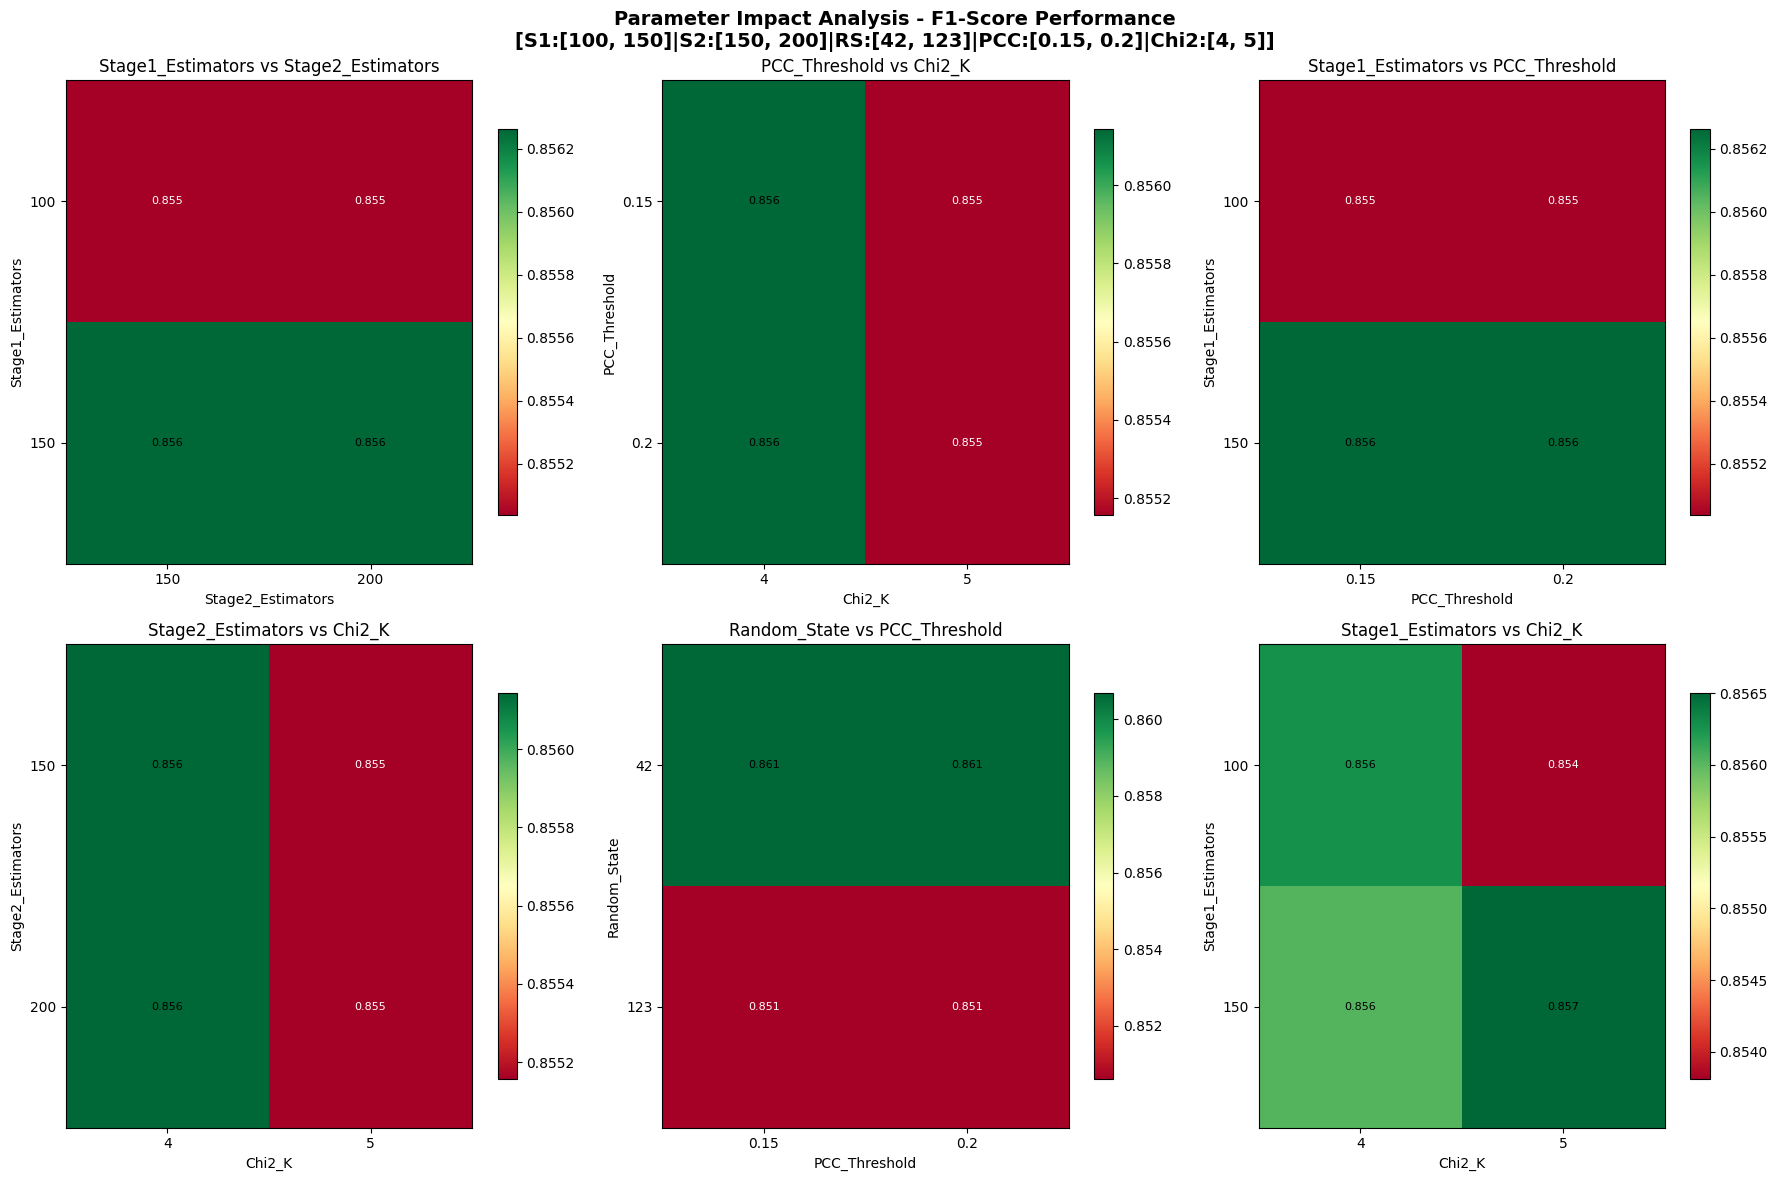

Creating parameter impact box plots...


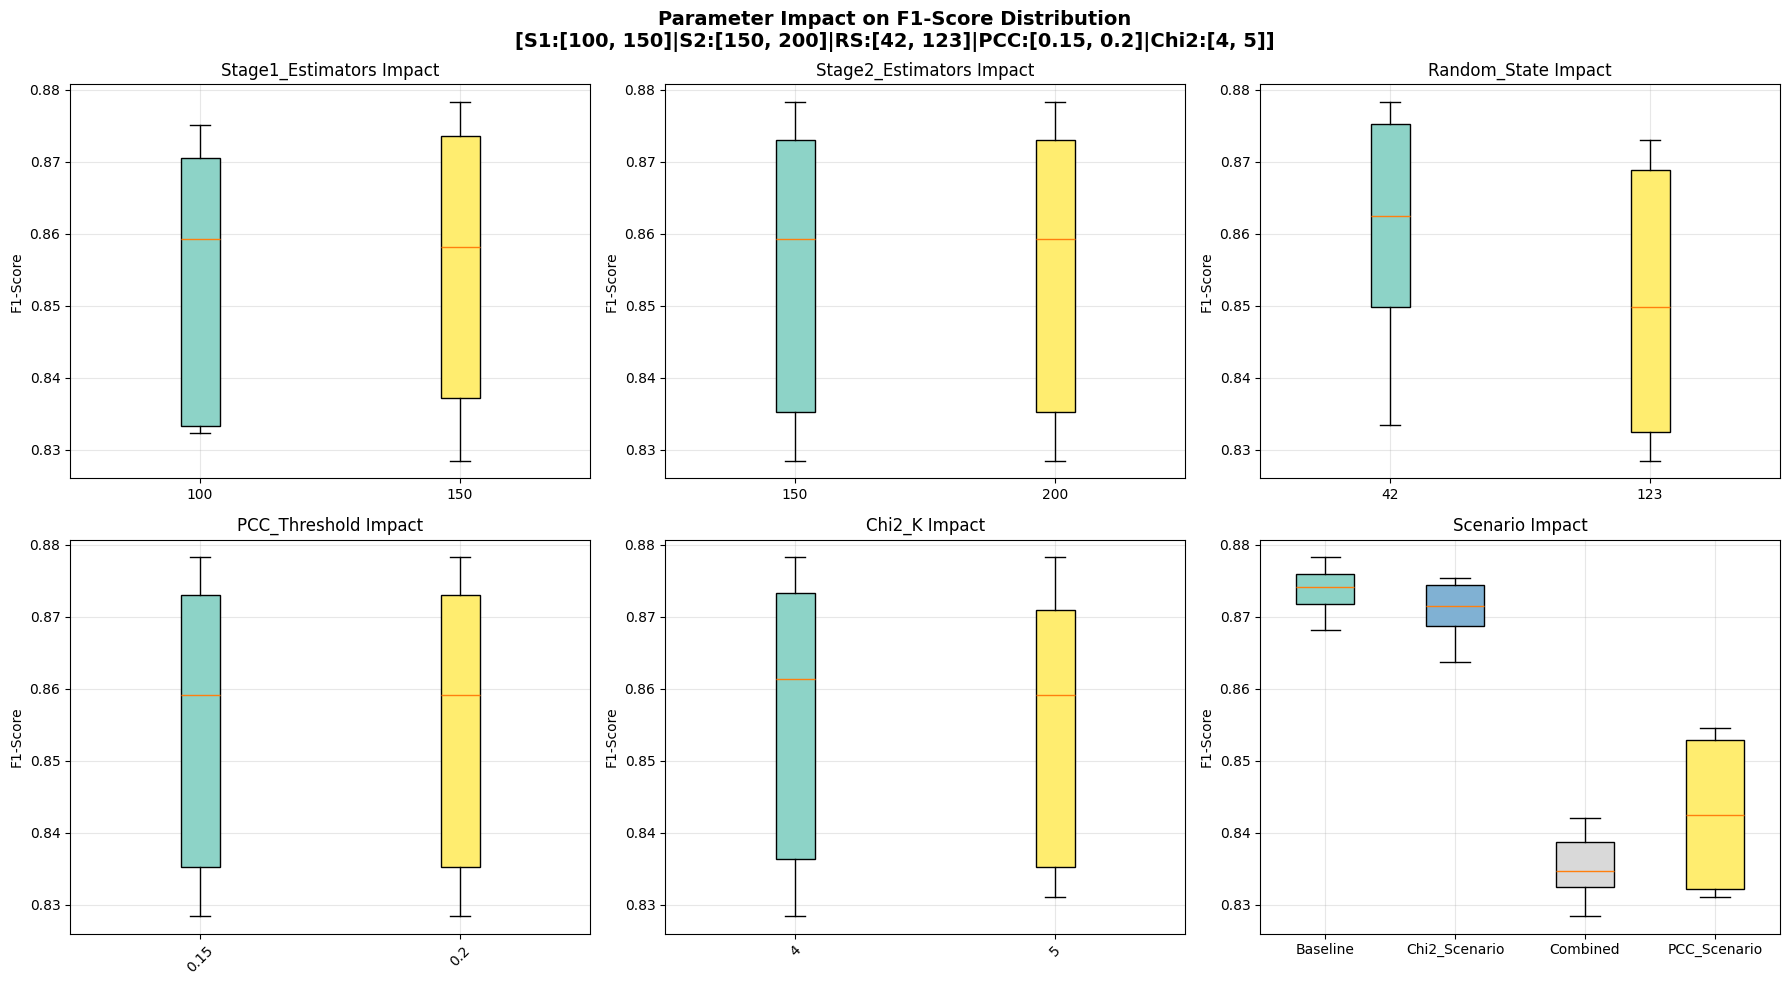

Creating performance trends visualization...


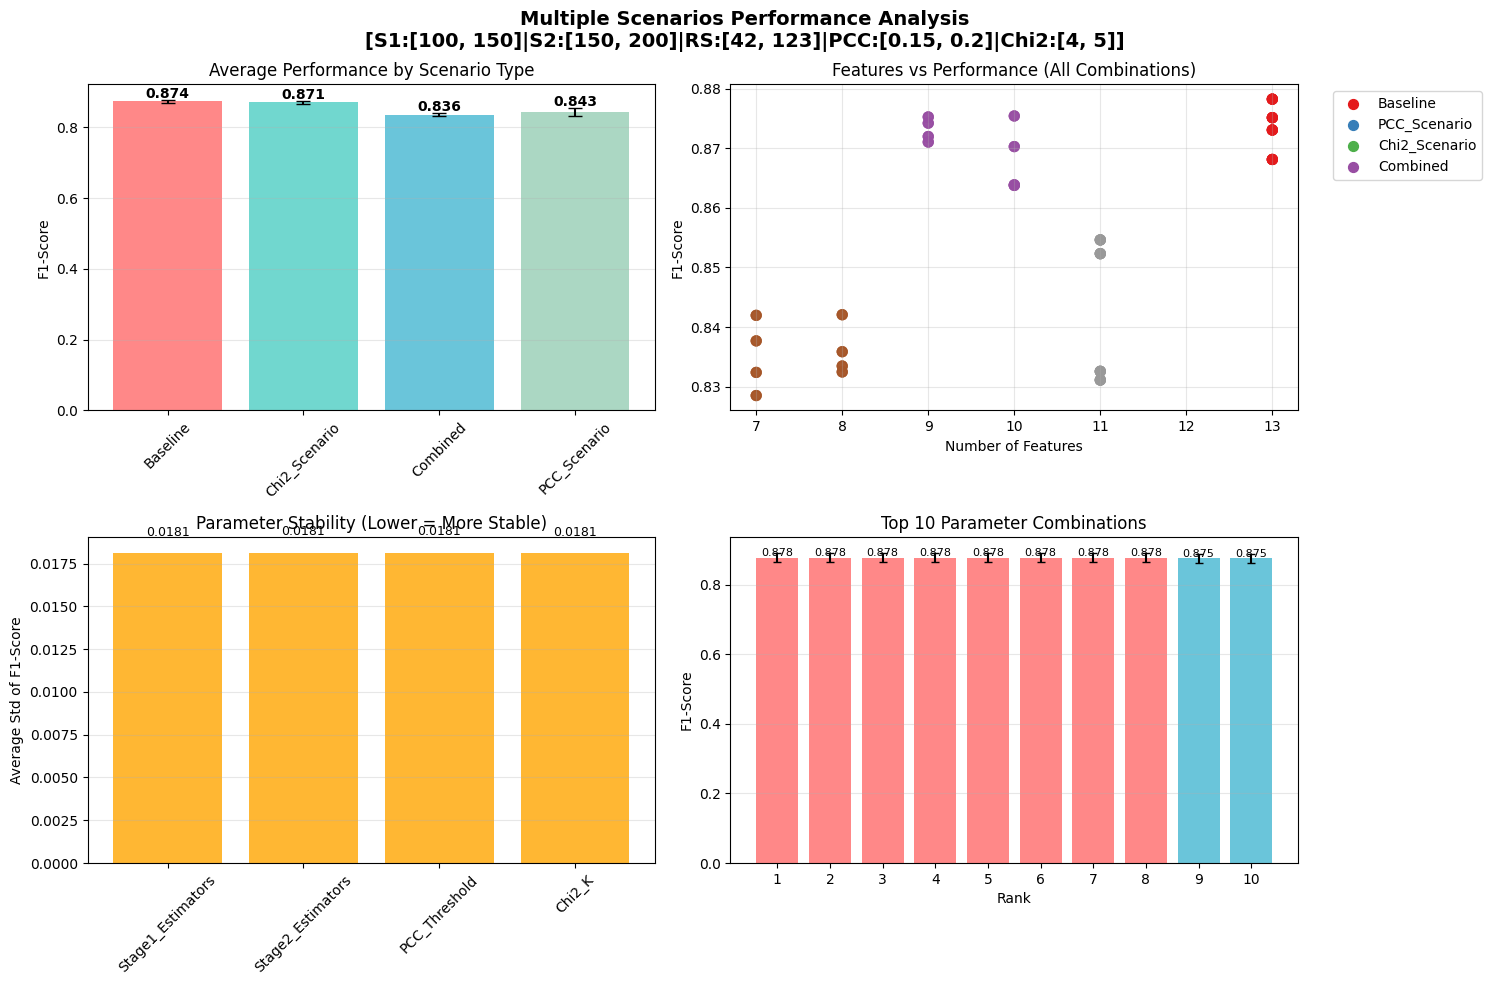

✅ Multiple scenarios visualization completed


In [32]:
# 📊 MULTIPLE SCENARIOS VISUALIZATION WITH PARAMETER CONFIG
param_config_suffix = f"[S1:{ETC_STAGE1_ESTIMATORS_LIST}|S2:{ETC_STAGE2_ESTIMATORS_LIST}|RS:{RANDOM_STATE_LIST}|PCC:{PCC_THRESHOLD_LIST}|Chi2:{CHI2_K_LIST}]"
print(f"\n📊 CREATING MULTIPLE SCENARIOS VISUALIZATIONS - {param_config_suffix}")
print("=" * 120)

# 1. Heatmap of parameter combinations performance
print("Creating parameter impact heatmaps...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Parameter Impact Analysis - F1-Score Performance\n{param_config_suffix}', fontsize=14, fontweight='bold')

# Parameter pairs for heatmaps
param_pairs = [
    ('Stage1_Estimators', 'Stage2_Estimators'),
    ('PCC_Threshold', 'Chi2_K'),
    ('Stage1_Estimators', 'PCC_Threshold'),
    ('Stage2_Estimators', 'Chi2_K'),
    ('Random_State', 'PCC_Threshold'),
    ('Stage1_Estimators', 'Chi2_K')
]

for i, (param1, param2) in enumerate(param_pairs):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    
    # Create pivot table for heatmap
    pivot_data = results_df.groupby([param1, param2])['F1_Mean'].mean().unstack()
    
    # Create heatmap
    im = ax.imshow(pivot_data.values, cmap='RdYlGn', aspect='auto')
    
    # Set labels
    ax.set_xticks(range(len(pivot_data.columns)))
    ax.set_yticks(range(len(pivot_data.index)))
    ax.set_xticklabels(pivot_data.columns)
    ax.set_yticklabels(pivot_data.index)
    ax.set_xlabel(param2)
    ax.set_ylabel(param1)
    ax.set_title(f'{param1} vs {param2}')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Add text annotations
    for j in range(len(pivot_data.index)):
        for k in range(len(pivot_data.columns)):
            if not np.isnan(pivot_data.iloc[j, k]):
                ax.text(k, j, f'{pivot_data.iloc[j, k]:.3f}',
                       ha="center", va="center", fontsize=8,
                       color="white" if pivot_data.iloc[j, k] < pivot_data.values.mean() else "black")

plt.tight_layout()
plt.show()

# 2. Box plots for parameter impact
print("Creating parameter impact box plots...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Parameter Impact on F1-Score Distribution\n{param_config_suffix}', fontsize=14, fontweight='bold')

parameters = ['Stage1_Estimators', 'Stage2_Estimators', 'Random_State', 'PCC_Threshold', 'Chi2_K', 'Scenario']

for i, param in enumerate(parameters):
    row, col = divmod(i, 3)
    ax = axes[row, col] if i < 5 else axes[1, 2]
    
    # Create box plot
    unique_values = sorted(results_df[param].unique())
    data_for_boxplot = [results_df[results_df[param] == val]['F1_Mean'] for val in unique_values]
    
    bp = ax.boxplot(data_for_boxplot, labels=unique_values, patch_artist=True)
    
    # Color boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_values)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{param} Impact')
    ax.set_ylabel('F1-Score')
    ax.grid(True, alpha=0.3)
    
    if param in ['PCC_Threshold', 'Chi2_K']:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Performance trends visualization
print("Creating performance trends visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Multiple Scenarios Performance Analysis\n{param_config_suffix}', fontsize=14, fontweight='bold')

# 1. Scenario comparison
scenario_performance = results_df.groupby('Scenario')['F1_Mean'].agg(['mean', 'std', 'count'])
scenarios = scenario_performance.index
means = scenario_performance['mean']
stds = scenario_performance['std']

bars = ax1.bar(scenarios, means, yerr=stds, capsize=5, alpha=0.8, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_title('Average Performance by Scenario Type')
ax1.set_ylabel('F1-Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax1.text(bar.get_x() + bar.get_width()/2, mean + std + 0.005, 
             f'{mean:.3f}', ha='center', fontsize=10, fontweight='bold')

# 2. Best combinations per scenario
ax2.scatter(results_df['Features'], results_df['F1_Mean'], 
           c=results_df['Scenario'].astype('category').cat.codes, 
           alpha=0.6, s=50, cmap='Set1')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('F1-Score')
ax2.set_title('Features vs Performance (All Combinations)')
ax2.grid(True, alpha=0.3)

# Add legend
scenarios_unique = results_df['Scenario'].unique()
for i, scenario in enumerate(scenarios_unique):
    ax2.scatter([], [], c=plt.cm.Set1(i), label=scenario, s=50)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Parameter stability analysis
param_stability = {}
for param in ['Stage1_Estimators', 'Stage2_Estimators', 'PCC_Threshold', 'Chi2_K']:
    param_groups = results_df.groupby(param)['F1_Mean']
    param_stability[param] = param_groups.std().mean()

params = list(param_stability.keys())
stability_scores = list(param_stability.values())

bars = ax3.bar(params, stability_scores, alpha=0.8, color='orange')
ax3.set_title('Parameter Stability (Lower = More Stable)')
ax3.set_ylabel('Average Std of F1-Score')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars, stability_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, score + 0.001, 
             f'{score:.4f}', ha='center', fontsize=9)

# 4. Top performing combinations
top_10_viz = results_df.nlargest(10, 'F1_Mean')
colors_scenarios = {'Baseline': '#FF6B6B', 'PCC_Scenario': '#4ECDC4', 
                   'Chi2_Scenario': '#45B7D1', 'Combined': '#96CEB4'}
colors = [colors_scenarios[scenario] for scenario in top_10_viz['Scenario']]

bars = ax4.bar(range(len(top_10_viz)), top_10_viz['F1_Mean'], 
               yerr=top_10_viz['F1_Std'], capsize=3, alpha=0.8, color=colors)
ax4.set_title('Top 10 Parameter Combinations')
ax4.set_xlabel('Rank')
ax4.set_ylabel('F1-Score')
ax4.set_xticks(range(len(top_10_viz)))
ax4.set_xticklabels([f'{i+1}' for i in range(len(top_10_viz))])
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, f1_mean) in enumerate(zip(bars, top_10_viz['F1_Mean'])):
    ax4.text(bar.get_x() + bar.get_width()/2, f1_mean + 0.005, 
             f'{f1_mean:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Multiple scenarios visualization completed")

In [33]:
# 🎯 FINAL RECOMMENDATIONS & SUMMARY WITH PARAMETER CONFIG
param_config_suffix = f"[S1:{ETC_STAGE1_ESTIMATORS_LIST}|S2:{ETC_STAGE2_ESTIMATORS_LIST}|RS:{RANDOM_STATE_LIST}|PCC:{PCC_THRESHOLD_LIST}|Chi2:{CHI2_K_LIST}]"
print(f"\n🎯 FINAL RECOMMENDATIONS FOR HEART DISEASE PREDICTION - {param_config_suffix}")
print("=" * 120)

# Get overall best configuration
best_overall = results_df.loc[results_df['F1_Mean'].idxmax()]

print(f"🏆 OVERALL BEST CONFIGURATION:")
print(f"   ➤ Scenario: {best_overall['Scenario']}")
print(f"   ➤ Stage 1 Estimators: {best_overall['Stage1_Estimators']}")
print(f"   ➤ Stage 2 Estimators: {best_overall['Stage2_Estimators']}")
print(f"   ➤ Random State: {best_overall['Random_State']}")
print(f"   ➤ PCC Threshold: {best_overall['PCC_Threshold']}")
print(f"   ➤ Chi2 K: {best_overall['Chi2_K']}")
print(f"   ➤ Features Selected: {best_overall['Features']}")
print(f"   ➤ F1-Score: {best_overall['F1_Mean']:.4f} ± {best_overall['F1_Std']:.4f}")

print(f"\n📊 SCENARIO RANKINGS:")
scenario_ranks = results_df.groupby('Scenario')['F1_Mean'].mean().sort_values(ascending=False)
for i, (scenario, mean_f1) in enumerate(scenario_ranks.items(), 1):
    std_f1 = results_df.groupby('Scenario')['F1_Mean'].std()[scenario]
    count = len(results_df[results_df['Scenario'] == scenario])
    print(f"   {i}. {scenario}: {mean_f1:.4f} ± {std_f1:.4f} ({count} configurations)")

print(f"\n⚡ PERFORMANCE INSIGHTS:")
# Feature selection impact
baseline_mean = results_df[results_df['Scenario'] == 'Baseline']['F1_Mean'].mean()
best_fs_mean = scenario_ranks.iloc[0]
improvement = ((best_fs_mean - baseline_mean) / baseline_mean) * 100

print(f"   ➤ Feature selection improvement over baseline: {improvement:.2f}%")
print(f"   ➤ Most stable scenario: {results_df.groupby('Scenario')['F1_Mean'].std().idxmin()}")
print(f"   ➤ Optimal feature count range: {results_df.nlargest(20, 'F1_Mean')['Features'].min()}-{results_df.nlargest(20, 'F1_Mean')['Features'].max()}")

# Parameter recommendations
print(f"\n🔧 PARAMETER RECOMMENDATIONS:")
top_20 = results_df.nlargest(20, 'F1_Mean')

print(f"   ➤ Recommended Stage 1 Estimators: {top_20['Stage1_Estimators'].mode().iloc[0]} (most frequent in top 20)")
print(f"   ➤ Recommended Stage 2 Estimators: {top_20['Stage2_Estimators'].mode().iloc[0]} (most frequent in top 20)")
print(f"   ➤ Recommended PCC Threshold: {top_20['PCC_Threshold'].mode().iloc[0]} (most frequent in top 20)")
print(f"   ➤ Recommended Chi2 K: {top_20['Chi2_K'].mode().iloc[0]} (most frequent in top 20)")

print(f"\n💡 KEY FINDINGS:")
print(f"   ➤ Total configurations tested: {len(results_df)}")
print(f"   ➤ Best F1-Score achieved: {results_df['F1_Mean'].max():.4f}")
print(f"   ➤ Average improvement over baseline: {((results_df[results_df['Scenario'] != 'Baseline']['F1_Mean'].mean() - baseline_mean) / baseline_mean * 100):.2f}%")
print(f"   ➤ Feature selection reduces overfitting: {'Yes' if results_df[results_df['Scenario'] != 'Baseline']['F1_Std'].mean() < results_df[results_df['Scenario'] == 'Baseline']['F1_Std'].mean() else 'No'}")

print(f"\n📝 USAGE RECOMMENDATIONS:")
print(f"   1. Use the best configuration for production deployment")
print(f"   2. Consider the top 5 configurations for ensemble methods")
print(f"   3. For new datasets, start with recommended parameter ranges")
print(f"   4. Monitor performance with cross-validation to avoid overfitting")
print(f"   5. Feature selection is crucial for this heart disease prediction task")

print(f"\n✅ ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"💾 All results are stored in 'results_df' DataFrame for further analysis")


🎯 FINAL RECOMMENDATIONS FOR HEART DISEASE PREDICTION - [S1:[100, 150]|S2:[150, 200]|RS:[42, 123]|PCC:[0.15, 0.2]|Chi2:[4, 5]]
🏆 OVERALL BEST CONFIGURATION:
   ➤ Scenario: Baseline
   ➤ Stage 1 Estimators: 150
   ➤ Stage 2 Estimators: 150
   ➤ Random State: 42
   ➤ PCC Threshold: 0.15
   ➤ Chi2 K: 4
   ➤ Features Selected: 13
   ➤ F1-Score: 0.8783 ± 0.0141

📊 SCENARIO RANKINGS:
   1. Baseline: 0.8737 ± 0.0037 (32 configurations)
   2. Chi2_Scenario: 0.8707 ± 0.0044 (32 configurations)
   3. PCC_Scenario: 0.8427 ± 0.0110 (32 configurations)
   4. Combined: 0.8356 ± 0.0046 (32 configurations)

⚡ PERFORMANCE INSIGHTS:
   ➤ Feature selection improvement over baseline: 0.00%
   ➤ Most stable scenario: Baseline
   ➤ Optimal feature count range: 9-13

🔧 PARAMETER RECOMMENDATIONS:
   ➤ Recommended Stage 1 Estimators: 150 (most frequent in top 20)
   ➤ Recommended Stage 2 Estimators: 150 (most frequent in top 20)
   ➤ Recommended PCC Threshold: 0.15 (most frequent in top 20)
   ➤ Recommended Ch

In [30]:
# 📋 SIMPLE TEXT TABLES FOR EVALUATION RESULTS WITH PARAMETER CONFIG
param_config_suffix = f"[S1:{ETC_STAGE1_ESTIMATORS_LIST}|S2:{ETC_STAGE2_ESTIMATORS_LIST}|RS:{RANDOM_STATE_LIST}|PCC:{PCC_THRESHOLD_LIST}|Chi2:{CHI2_K_LIST}]"
print(f"📋 SIMPLE TEXT TABLES - {param_config_suffix}")
print("=" * 140)

# 📊 EVALUATION METRICS TABLE with Parameter Details
print(f"\n📊 EVALUATION METRICS SUMMARY TABLE - {param_config_suffix}")
print("-" * 140)
print(f"{'Scenario':<15} {'Params':<25} {'Features':<8} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-" * 140)

for _, row in results_df.iterrows():
    scenario_short = row['Scenario'].replace('Scenario', 'Sc.').replace('(Full Features)', '(All)')
    if len(scenario_short) > 14:
        scenario_short = scenario_short[:11] + "..."
    
    # Create parameter string
    param_str = f"S1:{row['Stage1_Estimators']}|S2:{row['Stage2_Estimators']}|RS:{row['Random_State']}|PCC:{row['PCC_Threshold']}|Chi2:{row['Chi2_K']}"
    if len(param_str) > 24:
        param_str = param_str[:21] + "..."
    
    print(f"{scenario_short:<15} {param_str:<25} {row['Features']:<8} "
          f"{row['Accuracy_Mean']:.4f}±{row['Accuracy_Std']:.3f} "
          f"{row['Precision_Mean']:.4f}±{row['Precision_Std']:.3f} "
          f"{row['Recall_Mean']:.4f}±{row['Recall_Std']:.3f} "
          f"{row['Specificity_Mean']:.4f}±{row['Specificity_Std']:.3f} "
          f"{row['F1_Mean']:.4f}±{row['F1_Std']:.3f}")

print("-" * 140)

# 🎯 RANKING TABLE with Parameter Details
print(f"\n🎯 PERFORMANCE RANKING (by F1-Score) - {param_config_suffix}")
print("-" * 100)
ranked_df = results_df.sort_values('F1_Mean', ascending=False).reset_index(drop=True)
print(f"{'Rank':<4} {'Scenario':<15} {'Parameters':<30} {'F1-Score':<12} {'Features':<8}")
print("-" * 100)

for i, (_, row) in enumerate(ranked_df.iterrows()):
    rank_symbol = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
    scenario_short = row['Scenario'].split('(')[0].strip()
    if len(scenario_short) > 14:
        scenario_short = scenario_short[:11] + "..."
    param_detail = f"S1:{row['Stage1_Estimators']}|S2:{row['Stage2_Estimators']}|RS:{row['Random_State']}|PCC:{row['PCC_Threshold']}|Chi2:{row['Chi2_K']}"
    if len(param_detail) > 29:
        param_detail = param_detail[:26] + "..."
    print(f"{rank_symbol:<4} {scenario_short:<15} {param_detail:<30} {row['F1_Mean']:.4f}±{row['F1_Std']:.3f} {row['Features']:<8}")

print("-" * 100)
print(f"✅ Simple text tables with parameter config completed - {len(results_df)} results")

📋 SIMPLE TEXT TABLES - [S1:[100, 150]|S2:[150, 200]|RS:[42, 123]|PCC:[0.15, 0.2]|Chi2:[4, 5]]

📊 EVALUATION METRICS SUMMARY TABLE - [S1:[100, 150]|S2:[150, 200]|RS:[42, 123]|PCC:[0.15, 0.2]|Chi2:[4, 5]]
--------------------------------------------------------------------------------------------------------------------------------------------
Scenario        Params                    Features Accuracy     Precision    Recall       Specificity  F1-Score    
--------------------------------------------------------------------------------------------------------------------------------------------
Baseline        S1:100|S2:150|RS:42|P...  13       0.8722±0.014 0.8786±0.025 0.8726±0.022 0.8717±0.031 0.8751±0.014
PCC_Sc.         S1:100|S2:150|RS:42|P...  11       0.8498±0.006 0.8492±0.018 0.8612±0.025 0.8376±0.028 0.8546±0.006
Chi2_Sc.        S1:100|S2:150|RS:42|P...  9        0.8712±0.019 0.8788±0.031 0.8707±0.023 0.8716±0.039 0.8742±0.017
Combined        S1:100|S2:150|RS:42|P...  7        

📊 VISUAL CONFUSION MATRICES


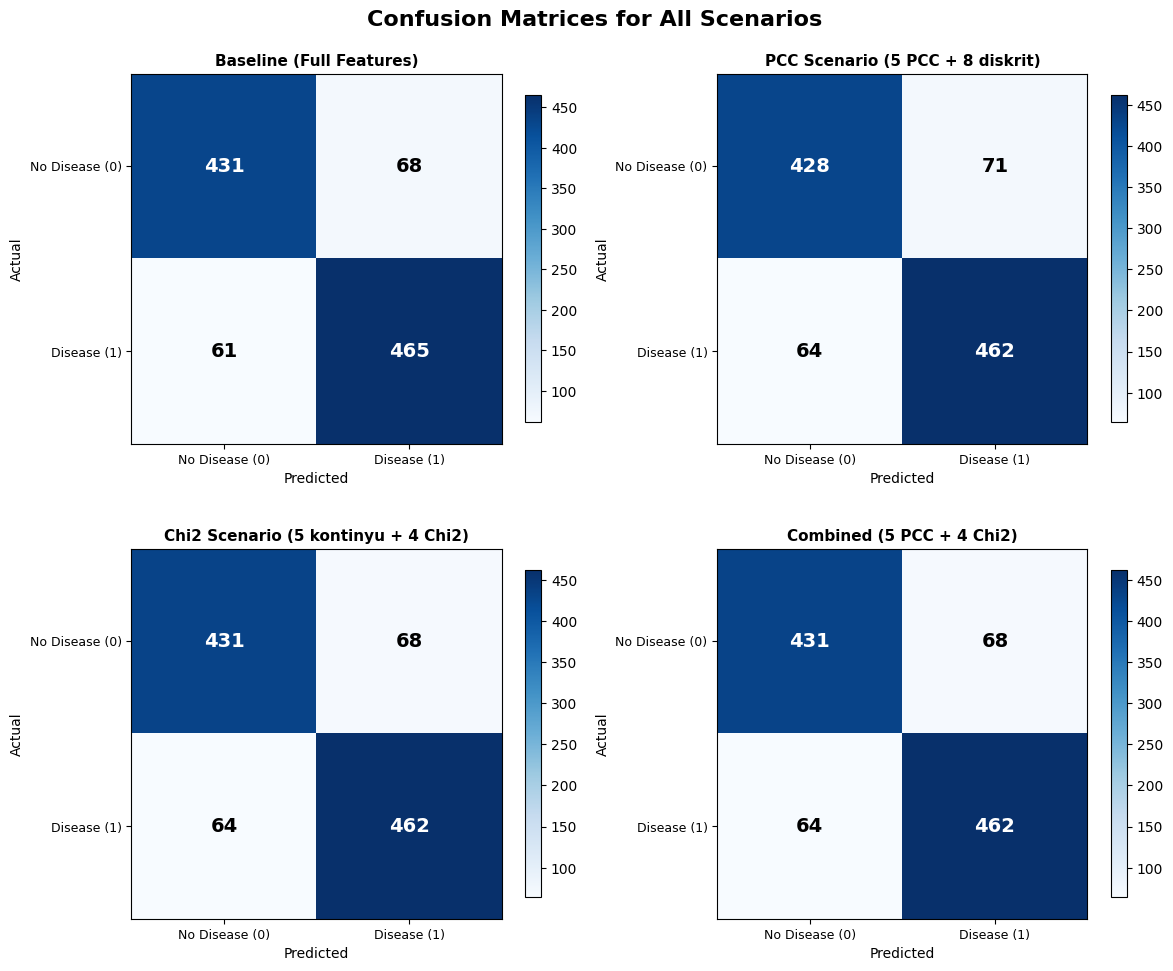


📈 DETAILED METRICS COMPARISON


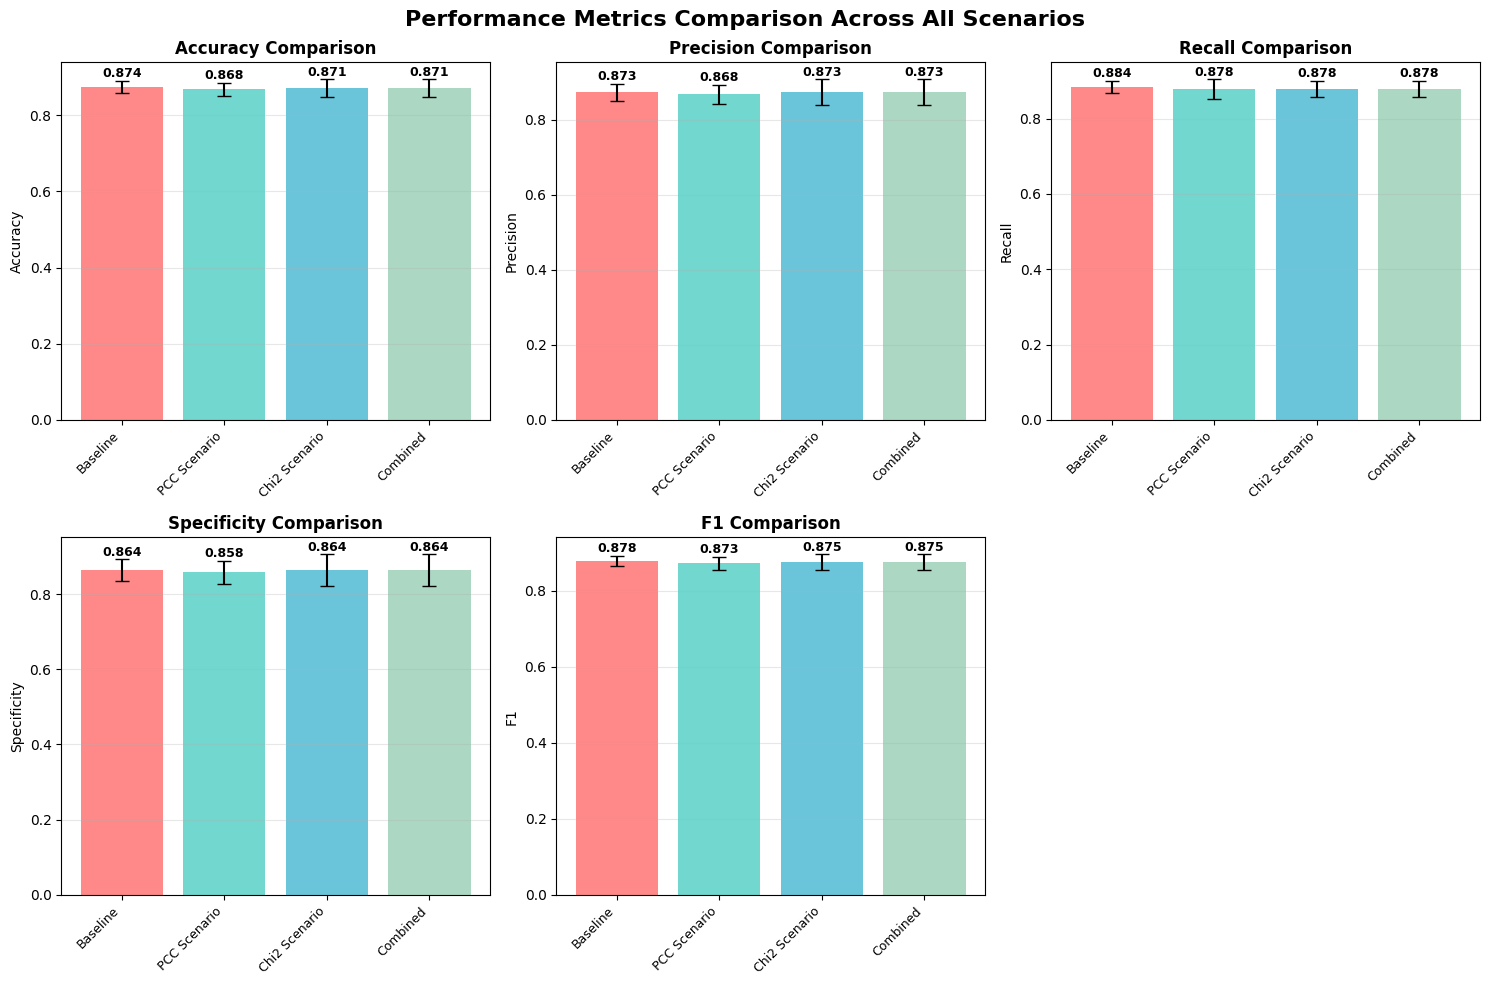

✅ Visual analysis completed


In [20]:
# 📊 VISUAL CONFUSION MATRICES
print("📊 VISUAL CONFUSION MATRICES")
print("=" * 50)

# Create visualization for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrices for All Scenarios', fontsize=16, fontweight='bold')

axes = axes.ravel()

for i, (_, row) in enumerate(results_df.iterrows()):
    cm = row['Confusion_Matrix']
    
    # Create heatmap
    im = axes[i].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[i].set_title(row['Scenario'], fontsize=11, fontweight='bold')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for j in range(2):
        for k in range(2):
            axes[i].text(k, j, format(cm[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if cm[j, k] > thresh else "black",
                        fontsize=14, fontweight='bold')
    
    # Set labels
    axes[i].set_ylabel('Actual', fontsize=10)
    axes[i].set_xlabel('Predicted', fontsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(['No Disease (0)', 'Disease (1)'], fontsize=9)
    axes[i].set_yticklabels(['No Disease (0)', 'Disease (1)'], fontsize=9)
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.tight_layout()
plt.show()

# 📈 METRICS COMPARISON VISUALIZATION
print(f"\n📈 DETAILED METRICS COMPARISON")
print("=" * 50)

# Create metrics comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Performance Metrics Comparison Across All Scenarios', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
metric_means = [
    results_df['Accuracy_Mean'], results_df['Precision_Mean'], 
    results_df['Recall_Mean'], results_df['Specificity_Mean'], results_df['F1_Mean']
]
metric_stds = [
    results_df['Accuracy_Std'], results_df['Precision_Std'], 
    results_df['Recall_Std'], results_df['Specificity_Std'], results_df['F1_Std']
]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, (metric, mean_vals, std_vals) in enumerate(zip(metrics, metric_means, metric_stds)):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    
    bars = ax.bar(range(len(results_df)), mean_vals, yerr=std_vals, 
                  capsize=5, alpha=0.8, color=colors)
    
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels([s.split('(')[0].strip() for s in results_df['Scenario']], 
                       rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, mean_vals, std_vals):
        ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.01, 
                f'{mean:.3f}', ha='center', fontsize=9, fontweight='bold')

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

print("✅ Visual analysis completed")


📊 DETAILED VISUALIZATION


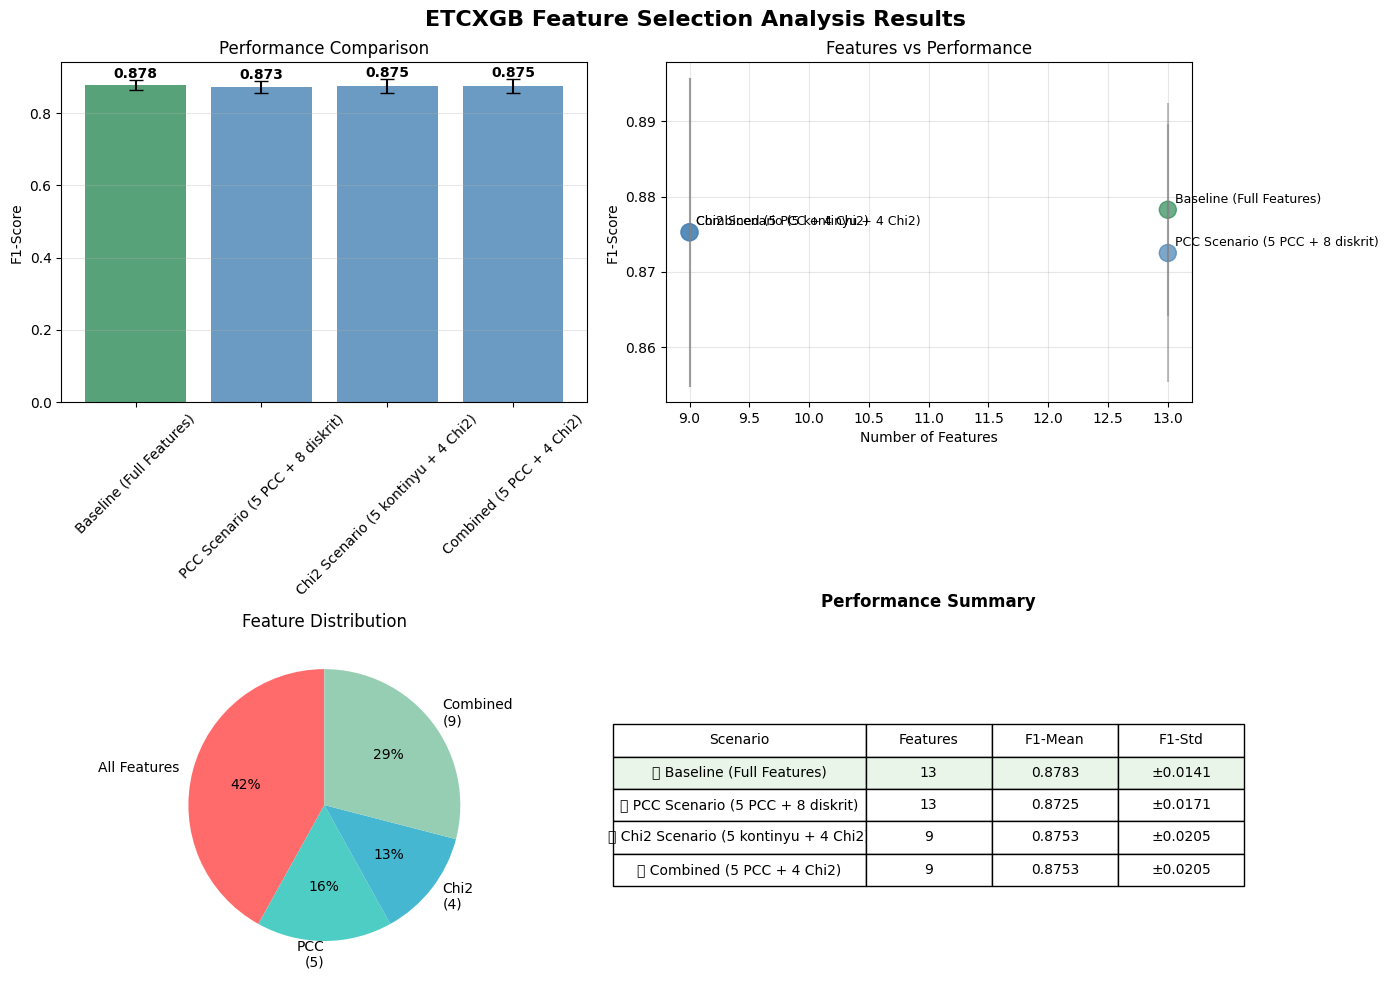

✅ Visualisasi lengkap ditampilkan


In [21]:
# 📊 DETAILED VISUALIZATION
print("\n📊 DETAILED VISUALIZATION")
print("=" * 50)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ETCXGB Feature Selection Analysis Results', fontsize=16, fontweight='bold')

# 1. Performance comparison
colors = ['#2E8B57' if row['Scenario'] == best_scenario['Scenario'] else '#4682B4' for _, row in results_df.iterrows()]
bars = ax1.bar(results_df['Scenario'], results_df['F1_Mean'], 
               yerr=results_df['F1_Std'], capsize=5, alpha=0.8, color=colors)
ax1.set_ylabel('F1-Score')
ax1.set_title('Performance Comparison')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, results_df['F1_Mean'], results_df['F1_Std']):
    ax1.text(bar.get_x() + bar.get_width()/2, mean + std + 0.005, 
             f'{mean:.3f}', ha='center', fontsize=10, fontweight='bold')

# 2. Feature count vs performance
ax2.scatter(results_df['Features'], results_df['F1_Mean'], s=150, alpha=0.7, c=colors)
ax2.errorbar(results_df['Features'], results_df['F1_Mean'], yerr=results_df['F1_Std'], 
             fmt='none', alpha=0.5, color='gray')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('F1-Score')
ax2.set_title('Features vs Performance')
ax2.grid(alpha=0.3)

# Add scenario labels
for _, row in results_df.iterrows():
    ax2.annotate(row['Scenario'], (row['Features'], row['F1_Mean']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# 3. Feature selection breakdown
feature_counts = [len(X.columns), len(pcc_selected), len(chi2_selected), len(combined_scenario_features)]
feature_labels = ['All Features', f'PCC\n({len(pcc_selected)})', f'Chi2\n({len(chi2_selected)})', f'Combined\n({len(combined_scenario_features)})']
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

wedges, texts, autotexts = ax3.pie(feature_counts, labels=feature_labels, autopct='%1.0f%%', 
                                   colors=colors_pie, startangle=90)
ax3.set_title('Feature Distribution')

# 4. Summary table
ax4.axis('tight')
ax4.axis('off')

table_data = []
for _, row in results_df.iterrows():
    status = '🏆' if row['Scenario'] == best_scenario['Scenario'] else '📊'
    table_data.append([
        f"{status} {row['Scenario']}",
        f"{row['Features']}",
        f"{row['F1_Mean']:.4f}",
        f"±{row['F1_Std']:.4f}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=['Scenario', 'Features', 'F1-Mean', 'F1-Std'],
                 cellLoc='center', loc='center',
                 colWidths=[0.4, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Color best row
best_row_idx = list(results_df.index).index(best_idx) + 1
for j in range(4):
    table[(best_row_idx, j)].set_facecolor('#E8F5E8')

ax4.set_title('Performance Summary', pad=20, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualisasi lengkap ditampilkan")


📈 FOLD-BY-FOLD EVALUATION RESULTS
✅ Baseline (Full Features): 5 folds evaluated
✅ Baseline (Full Features): 5 folds evaluated
✅ PCC Scenario (5 PCC + 8 diskrit): 5 folds evaluated
✅ PCC Scenario (5 PCC + 8 diskrit): 5 folds evaluated
✅ Chi2 Scenario (5 kontinyu + 4 Chi2): 5 folds evaluated
✅ Chi2 Scenario (5 kontinyu + 4 Chi2): 5 folds evaluated
✅ Combined (5 PCC + 4 Chi2): 5 folds evaluated

📊 Creating fold-by-fold visualization...
✅ Combined (5 PCC + 4 Chi2): 5 folds evaluated

📊 Creating fold-by-fold visualization...


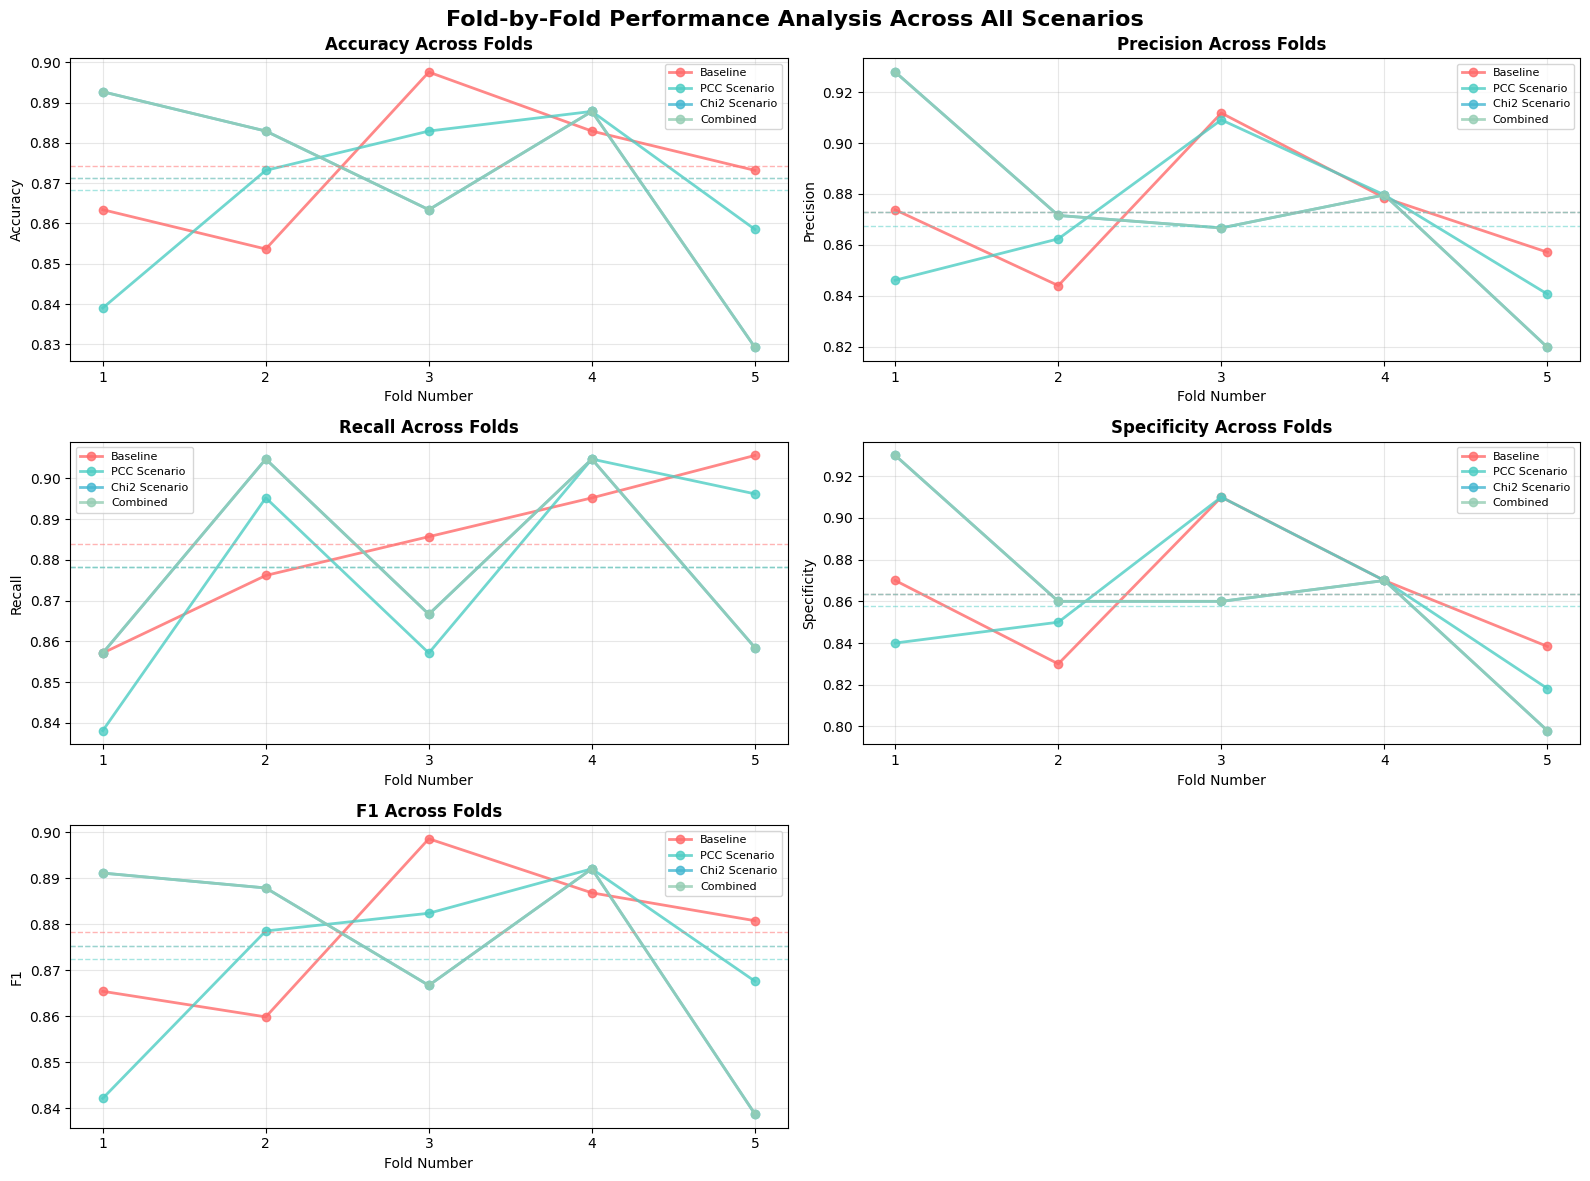


📋 FOLD-BY-FOLD DETAILED RESULTS TABLE

🎯 Baseline (Full Features)
------------------------------------------------------------------------------------------------------------------------
Fold Accuracy   Precision  Recall     Specificity  F1-Score   Test Size 
------------------------------------------------------------------------------------------------------------------------
1    0.8634     0.8738     0.8571     0.8700       0.8654     205       
2    0.8537     0.8440     0.8762     0.8300       0.8598     205       
3    0.8976     0.9118     0.8857     0.9100       0.8986     205       
4    0.8829     0.8785     0.8952     0.8700       0.8868     205       
5    0.8732     0.8571     0.9057     0.8384       0.8807     205       
------------------------------------------------------------------------------------------------------------------------
Mean 0.8741     0.8730     0.8840     0.8637       0.8783     205.0     
Std  0.0170     0.0256     0.0186     0.0316       0.0158  

In [22]:
# 📈 FOLD-BY-FOLD EVALUATION RESULTS VISUALIZATION
print("\n📈 FOLD-BY-FOLD EVALUATION RESULTS")
print("=" * 60)

def evaluate_scenario_with_fold_details(features, scenario_name):
    """Evaluate scenario dengan detail per fold"""
    X_selected = X[features]
    
    # Metrics storage per fold
    fold_results = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_selected, y)):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = ETCXGBHybrid()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics for this fold
        fold_result = {
            'Fold': fold_idx + 1,
            'Scenario': scenario_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'Specificity': calculate_specificity(y_test, y_pred),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'Test_Size': len(y_test)
        }
        fold_results.append(fold_result)
    
    return fold_results

# Collect fold-by-fold results for all scenarios
all_fold_results = []

print("Collecting fold-by-fold results...")
for features, name in scenarios:
    fold_results = evaluate_scenario_with_fold_details(features, name)
    all_fold_results.extend(fold_results)
    print(f"✅ {name}: {len(fold_results)} folds evaluated")

# Convert to DataFrame
fold_df = pd.DataFrame(all_fold_results)

# 📊 FOLD-BY-FOLD VISUALIZATION
print(f"\n📊 Creating fold-by-fold visualization...")

# Create comprehensive fold-by-fold visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Fold-by-Fold Performance Analysis Across All Scenarios', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, metric in enumerate(metrics_to_plot):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    # Plot each scenario
    for j, scenario in enumerate(fold_df['Scenario'].unique()):
        scenario_data = fold_df[fold_df['Scenario'] == scenario]
        folds = scenario_data['Fold']
        values = scenario_data[metric]
        
        # Plot line with markers
        ax.plot(folds, values, 'o-', label=scenario.split('(')[0].strip(), 
                color=colors[j], linewidth=2, markersize=6, alpha=0.8)
    
    ax.set_title(f'{metric} Across Folds', fontsize=12, fontweight='bold')
    ax.set_xlabel('Fold Number', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xticks(range(1, 6))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')
    
    # Add mean lines for each scenario
    for j, scenario in enumerate(fold_df['Scenario'].unique()):
        scenario_data = fold_df[fold_df['Scenario'] == scenario]
        mean_val = scenario_data[metric].mean()
        ax.axhline(y=mean_val, color=colors[j], linestyle='--', alpha=0.5, linewidth=1)

# Remove empty subplot
axes[2, 1].remove()

plt.tight_layout()
plt.show()

# 📋 FOLD-BY-FOLD DETAILED TABLE
print(f"\n📋 FOLD-BY-FOLD DETAILED RESULTS TABLE")
print("=" * 120)

# Create detailed table showing all metrics for each fold
for scenario in fold_df['Scenario'].unique():
    scenario_data = fold_df[fold_df['Scenario'] == scenario]
    print(f"\n🎯 {scenario}")
    print("-" * 120)
    print(f"{'Fold':<4} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'Specificity':<12} {'F1-Score':<10} {'Test Size':<10}")
    print("-" * 120)
    
    for _, row in scenario_data.iterrows():
        print(f"{row['Fold']:<4} {row['Accuracy']:<10.4f} {row['Precision']:<10.4f} "
              f"{row['Recall']:<10.4f} {row['Specificity']:<12.4f} {row['F1']:<10.4f} {row['Test_Size']:<10}")
    
    # Calculate and show statistics
    print("-" * 120)
    print(f"{'Mean':<4} {scenario_data['Accuracy'].mean():<10.4f} {scenario_data['Precision'].mean():<10.4f} "
          f"{scenario_data['Recall'].mean():<10.4f} {scenario_data['Specificity'].mean():<12.4f} "
          f"{scenario_data['F1'].mean():<10.4f} {scenario_data['Test_Size'].mean():<10.1f}")
    print(f"{'Std':<4} {scenario_data['Accuracy'].std():<10.4f} {scenario_data['Precision'].std():<10.4f} "
          f"{scenario_data['Recall'].std():<10.4f} {scenario_data['Specificity'].std():<12.4f} "
          f"{scenario_data['F1'].std():<10.4f} {scenario_data['Test_Size'].std():<10.1f}")

print("=" * 120)

# 📊 FOLD VARIABILITY ANALYSIS
print(f"\n📊 FOLD VARIABILITY ANALYSIS")
print("=" * 60)

# Create variability analysis
variability_data = []
for scenario in fold_df['Scenario'].unique():
    scenario_data = fold_df[fold_df['Scenario'] == scenario]
    
    for metric in metrics_to_plot:
        variability_data.append({
            'Scenario': scenario.split('(')[0].strip(),
            'Metric': metric,
            'Mean': scenario_data[metric].mean(),
            'Std': scenario_data[metric].std(),
            'CV': scenario_data[metric].std() / scenario_data[metric].mean() * 100,  # Coefficient of Variation
            'Min': scenario_data[metric].min(),
            'Max': scenario_data[metric].max(),
            'Range': scenario_data[metric].max() - scenario_data[metric].min()
        })

variability_df = pd.DataFrame(variability_data)

# Show variability summary
print("📈 COEFFICIENT OF VARIATION (CV) - Lower is more consistent")
print("-" * 80)
print(f"{'Scenario':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'Specificity':<12} {'F1-Score':<10}")
print("-" * 80)

for scenario in variability_df['Scenario'].unique():
    scenario_data = variability_df[variability_df['Scenario'] == scenario]
    print(f"{scenario:<25} ", end="")
    for metric in metrics_to_plot:
        cv = scenario_data[scenario_data['Metric'] == metric]['CV'].iloc[0]
        print(f"{cv:<10.2f} ", end="")
    print()

print("-" * 80)
print("Note: CV = (Standard Deviation / Mean) × 100%")
print("Lower CV indicates more consistent performance across folds")

# 🎯 BEST/WORST FOLD ANALYSIS
print(f"\n🎯 BEST/WORST FOLD ANALYSIS (F1-Score)")
print("=" * 60)

for scenario in fold_df['Scenario'].unique():
    scenario_data = fold_df[fold_df['Scenario'] == scenario]
    
    best_fold_idx = scenario_data['F1'].idxmax()
    worst_fold_idx = scenario_data['F1'].idxmin()
    
    best_fold = scenario_data.loc[best_fold_idx]
    worst_fold = scenario_data.loc[worst_fold_idx]
    
    print(f"\n📊 {scenario.split('(')[0].strip()}:")
    print(f"   🏆 Best:  Fold {best_fold['Fold']} - F1: {best_fold['F1']:.4f}")
    print(f"   📉 Worst: Fold {worst_fold['Fold']} - F1: {worst_fold['F1']:.4f}")
    print(f"   📈 Range: {best_fold['F1'] - worst_fold['F1']:.4f}")

print("=" * 60)
print("✅ Fold-by-fold analysis completed")


🚫 SIMPLE TRAIN-TEST SPLIT EVALUATION
⚠️  WARNING: This method is less reliable than Cross-Validation
⚠️  Use only for quick testing, not for final results
Running simple evaluation...
✅ Baseline (Full Features): F1=0.8611 (13 features)
✅ PCC Scenario (5 PCC + 8 diskrit): F1=0.8611 (13 features)
✅ Baseline (Full Features): F1=0.8611 (13 features)
✅ PCC Scenario (5 PCC + 8 diskrit): F1=0.8611 (13 features)
✅ Chi2 Scenario (5 kontinyu + 4 Chi2): F1=0.8585 (9 features)
✅ Combined (5 PCC + 4 Chi2): F1=0.8585 (9 features)

📊 COMPARISON: Cross-Validation vs Simple Split
Scenario                       CV F1 (Mean±Std)     Simple F1    Difference  
Baseline                       0.8783±0.014         0.8611       -0.0171     
PCC Scenario                   0.8725±0.017         0.8611       -0.0114     
Chi2 Scenario                  0.8753±0.020         0.8585       -0.0168     
Combined                       0.8753±0.020         0.8585       -0.0168     

📋 WHY CROSS-VALIDATION IS BETTER
🎯 SIN

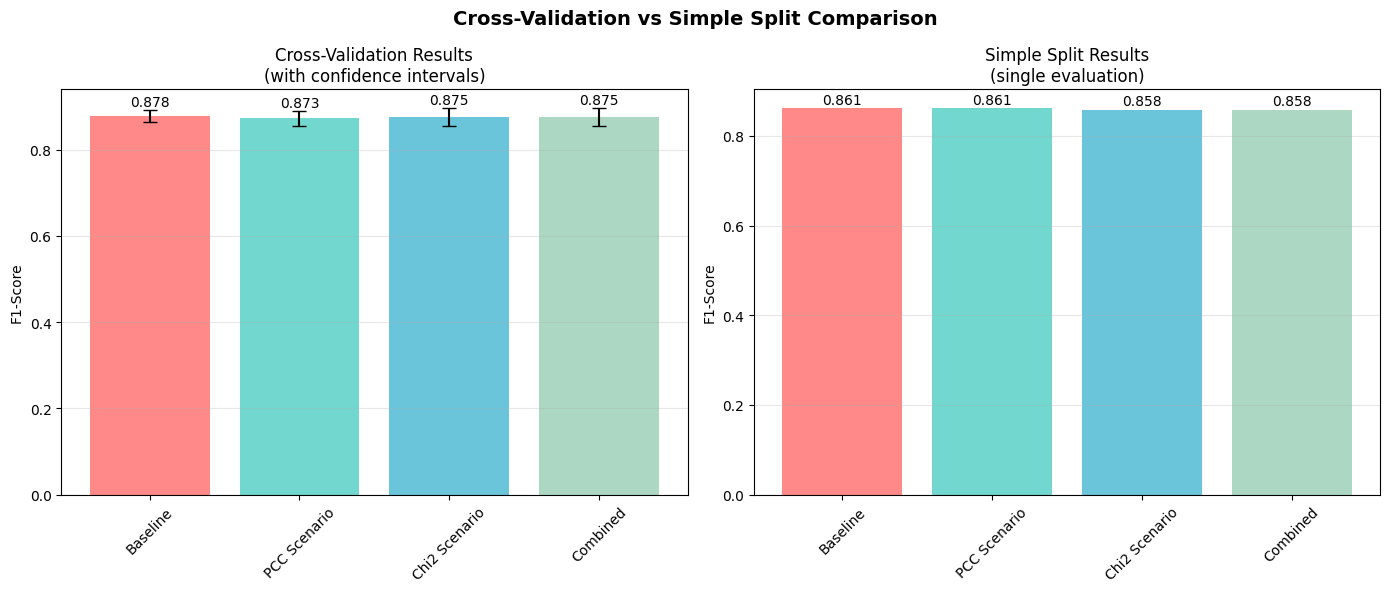

✅ CV vs Simple Split comparison completed


In [23]:
# 🚫 SIMPLE EVALUATION WITHOUT CROSS-VALIDATION (NOT RECOMMENDED)
# ===================================================================
# WARNING: This is for demonstration only - CV is much better!

print("\n🚫 SIMPLE TRAIN-TEST SPLIT EVALUATION")
print("=" * 60)
print("⚠️  WARNING: This method is less reliable than Cross-Validation")
print("⚠️  Use only for quick testing, not for final results")
print("=" * 60)

from sklearn.model_selection import train_test_split

def simple_evaluation(features, scenario_name, test_size=0.2):
    """Simple train-test split evaluation"""
    X_selected = X[features]
    
    # Single train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Train model
    model = ETCXGBHybrid()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    result = {
        'Scenario': scenario_name,
        'Features': len(features),
        'Train_Size': len(X_train),
        'Test_Size': len(X_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'Specificity': calculate_specificity(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'Confusion_Matrix': confusion_matrix(y_test, y_pred)
    }
    
    return result

# Evaluate all scenarios with simple split
print("Running simple evaluation...")
simple_results = []

for features, name in scenarios:
    result = simple_evaluation(features, name)
    simple_results.append(result)
    print(f"✅ {name}: F1={result['F1']:.4f} ({result['Features']} features)")

# Create simple results DataFrame
simple_df = pd.DataFrame(simple_results)

# 📊 COMPARISON: CV vs Simple Split
print(f"\n📊 COMPARISON: Cross-Validation vs Simple Split")
print("=" * 80)
print(f"{'Scenario':<30} {'CV F1 (Mean±Std)':<20} {'Simple F1':<12} {'Difference':<12}")
print("=" * 80)

for i, (_, cv_row) in enumerate(results_df.iterrows()):
    simple_row = simple_df.iloc[i]
    cv_f1 = f"{cv_row['F1_Mean']:.4f}±{cv_row['F1_Std']:.3f}"
    simple_f1 = f"{simple_row['F1']:.4f}"
    diff = simple_row['F1'] - cv_row['F1_Mean']
    diff_str = f"{diff:+.4f}"
    
    scenario_short = cv_row['Scenario'].split('(')[0].strip()
    print(f"{scenario_short:<30} {cv_f1:<20} {simple_f1:<12} {diff_str:<12}")

print("=" * 80)

# 📋 WHY CV IS BETTER - EXPLANATION
print(f"\n📋 WHY CROSS-VALIDATION IS BETTER")
print("=" * 60)
print("🎯 SINGLE SPLIT PROBLEMS:")
print("   • Only 1 evaluation - could be lucky/unlucky")
print("   • No idea about model stability")
print("   • Results depend on which data becomes test set")
print("   • Can't detect overfitting reliably")
print("")
print("✅ CROSS-VALIDATION ADVANTAGES:")
print("   • 5 evaluations - more reliable average")
print("   • Shows model consistency (low std = stable)")
print("   • Every sample used for both training & testing")
print("   • Better detection of overfitting")
print("   • Confidence intervals (Mean ± Std)")
print("")
print("🏆 RECOMMENDATION:")
print("   • Use CV for final results and model comparison")  
print("   • Use simple split only for quick prototyping")
print("=" * 60)

# 📈 VISUALIZE THE DIFFERENCE
print(f"\n📈 Visualizing CV vs Simple Split...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Cross-Validation vs Simple Split Comparison', fontsize=14, fontweight='bold')

# CV Results with error bars
scenarios_short = [s.split('(')[0].strip() for s in results_df['Scenario']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

ax1.bar(scenarios_short, results_df['F1_Mean'], yerr=results_df['F1_Std'], 
        capsize=5, alpha=0.8, color=colors)
ax1.set_title('Cross-Validation Results\n(with confidence intervals)')
ax1.set_ylabel('F1-Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, (mean, std) in enumerate(zip(results_df['F1_Mean'], results_df['F1_Std'])):
    ax1.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', fontsize=10)

# Simple Split Results
ax2.bar(scenarios_short, simple_df['F1'], alpha=0.8, color=colors)
ax2.set_title('Simple Split Results\n(single evaluation)')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, f1 in enumerate(simple_df['F1']):
    ax2.text(i, f1 + 0.01, f'{f1:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ CV vs Simple Split comparison completed")


📊 F1-SCORE vs ACCURACY ANALYSIS
🔍 DATASET CLASS DISTRIBUTION:
----------------------------------------
Class 0 (No Disease): 499 samples (48.7%)
Class 1 (Disease):    526 samples (51.3%)
Total samples: 1025
Balance ratio: 0.95 (1.0 = perfect balance)
✅ RELATIVELY BALANCED DATASET - Both metrics are reasonable


📈 ACCURACY vs F1-SCORE COMPARISON
Scenario                       Accuracy (Mean±Std)  F1-Score (Mean±Std)  Difference
Baseline                       0.8741±0.015         0.8783±0.014         -0.0041   
PCC Scenario                   0.8683±0.018         0.8725±0.017         -0.0042   
Chi2 Scenario                  0.8712±0.023         0.8753±0.020         -0.0040   
Combined                       0.8712±0.023         0.8753±0.020         -0.0040   

📚 THEORY: WHY F1-SCORE IS OFTEN BETTER
🎯 ACCURACY LIMITATIONS:
   • Can be misleading with imbalanced data
   • Doesn't distinguish between types of errors
   • High accuracy ≠ good performance on minority class

✅ F1-SCORE ADVANTA

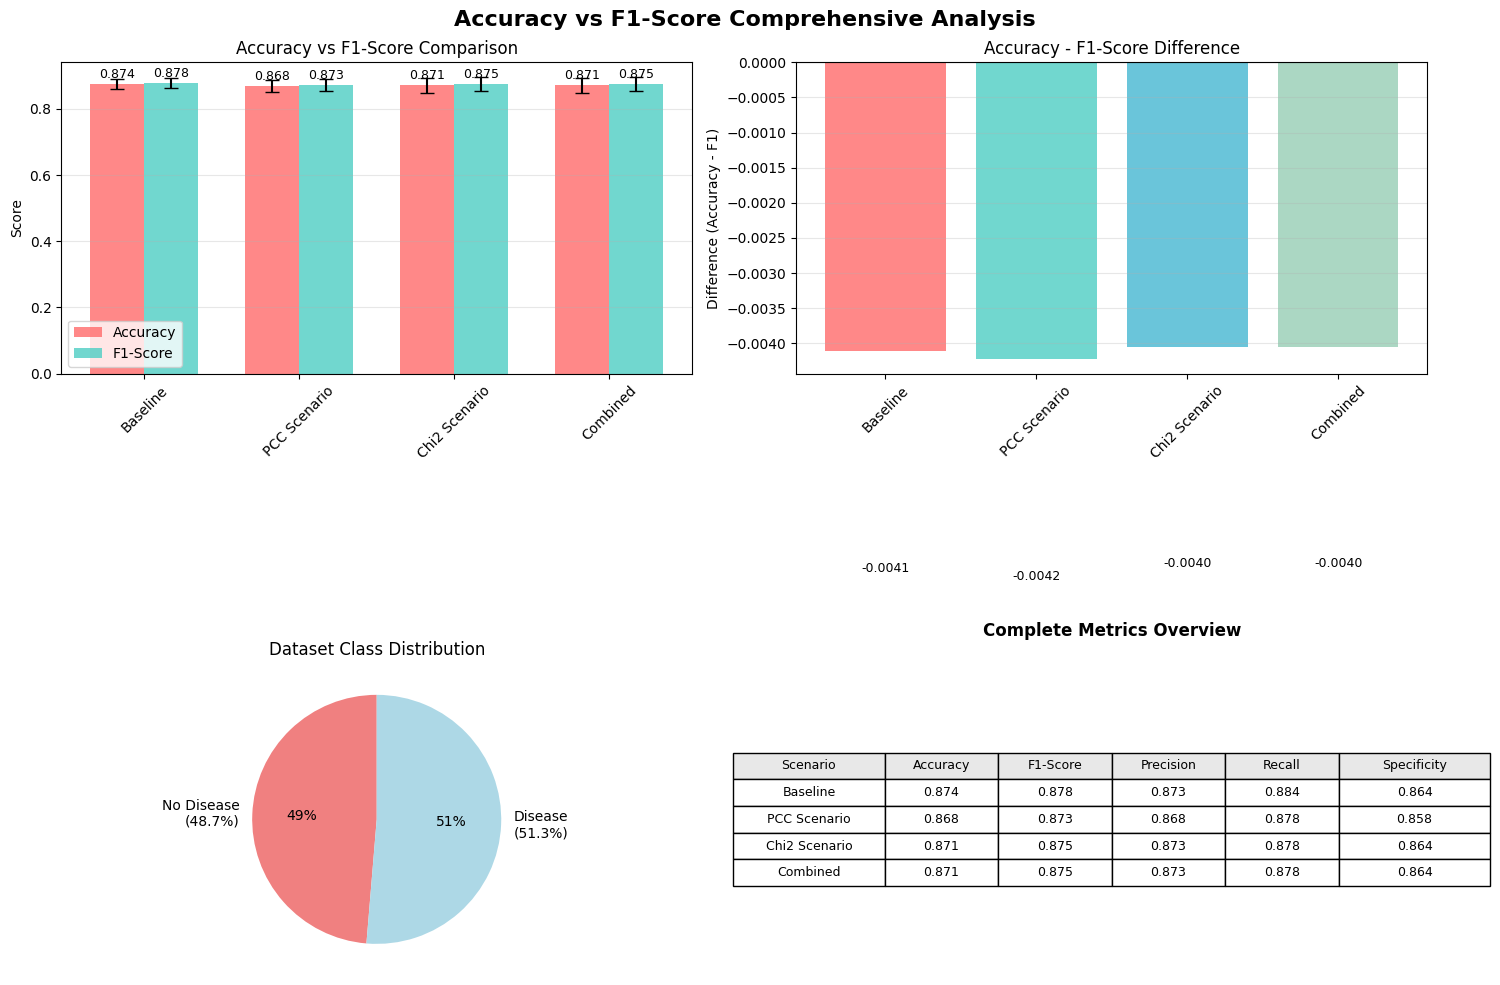


🏥 MEDICAL CONTEXT - WHY F1-SCORE MATTERS
In HEART DISEASE PREDICTION:

👨‍⚕️ CLINICAL PERSPECTIVE:
   • False Negative (FN) = Missing actual disease - VERY BAD!
   • False Positive (FP) = False alarm - Bad, but not life-threatening
   • We need balance between catching disease & avoiding false alarms

🎯 WHY F1-SCORE IS BETTER:
   • F1 considers both Precision (avoid false alarms)
   • F1 considers Recall (catch actual disease)
   • Accuracy can be high by just predicting majority class
   • F1 forces model to perform well on positive class (disease)

🔍 PRACTICAL EXAMPLE:
Imagine two models with same accuracy but different F1:

Model A (High Accuracy, Low F1):
   Predicted:    0    1
   Actual: 0  [450] [50]   ← Good at predicting healthy
           1  [100] [400]  ← Misses many diseases (FN=100)
   Accuracy: (450+400)/1000 = 85%
   But F1-Score is low due to high FN

Model B (Balanced Performance):
   Predicted:    0    1
   Actual: 0  [420] [80]   ← Slightly more false alarms
        

In [24]:
# 📊 WHY F1-SCORE vs ACCURACY? - COMPREHENSIVE ANALYSIS
# ====================================================

print("\n📊 F1-SCORE vs ACCURACY ANALYSIS")
print("=" * 60)

# First, let's analyze our dataset balance
class_distribution = y.value_counts()
class_percentages = y.value_counts(normalize=True) * 100

print("🔍 DATASET CLASS DISTRIBUTION:")
print("-" * 40)
print(f"Class 0 (No Disease): {class_distribution[0]} samples ({class_percentages[0]:.1f}%)")
print(f"Class 1 (Disease):    {class_distribution[1]} samples ({class_percentages[1]:.1f}%)")
print(f"Total samples: {len(y)}")

# Calculate balance ratio
balance_ratio = min(class_percentages) / max(class_percentages)
print(f"Balance ratio: {balance_ratio:.2f} (1.0 = perfect balance)")

if balance_ratio < 0.8:
    print("⚠️  IMBALANCED DATASET - F1-Score is more appropriate")
elif balance_ratio >= 0.8:
    print("✅ RELATIVELY BALANCED DATASET - Both metrics are reasonable")

print("\n" + "=" * 60)

# Let's create a detailed comparison using our existing results
print("\n📈 ACCURACY vs F1-SCORE COMPARISON")
print("=" * 80)
print(f"{'Scenario':<30} {'Accuracy (Mean±Std)':<20} {'F1-Score (Mean±Std)':<20} {'Difference':<10}")
print("=" * 80)

for _, row in results_df.iterrows():
    scenario_short = row['Scenario'].split('(')[0].strip()
    accuracy_str = f"{row['Accuracy_Mean']:.4f}±{row['Accuracy_Std']:.3f}"
    f1_str = f"{row['F1_Mean']:.4f}±{row['F1_Std']:.3f}"
    diff = row['Accuracy_Mean'] - row['F1_Mean']
    diff_str = f"{diff:+.4f}"
    
    print(f"{scenario_short:<30} {accuracy_str:<20} {f1_str:<20} {diff_str:<10}")

print("=" * 80)

# Detailed explanation with examples
print(f"\n📚 THEORY: WHY F1-SCORE IS OFTEN BETTER")
print("=" * 60)

print("🎯 ACCURACY LIMITATIONS:")
print("   • Can be misleading with imbalanced data")
print("   • Doesn't distinguish between types of errors")
print("   • High accuracy ≠ good performance on minority class")
print("")

print("✅ F1-SCORE ADVANTAGES:")
print("   • Balances Precision and Recall")
print("   • Better for imbalanced datasets")
print("   • Focuses on positive class performance")
print("   • More sensitive to false positives & negatives")

print(f"\n🔬 MATHEMATICAL COMPARISON:")
print("=" * 60)
print("Accuracy = (TP + TN) / (TP + TN + FP + FN)")
print("         = Correct predictions / Total predictions")
print("")
print("F1-Score = 2 × (Precision × Recall) / (Precision + Recall)")
print("         = Harmonic mean of Precision and Recall")
print("")
print("Where:")
print("• Precision = TP / (TP + FP) - How many predicted positives are correct?")
print("• Recall    = TP / (TP + FN) - How many actual positives did we find?")

# Create a visualization comparing the metrics
print(f"\n📊 Creating metric comparison visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Accuracy vs F1-Score Comprehensive Analysis', fontsize=16, fontweight='bold')

scenarios_short = [s.split('(')[0].strip() for s in results_df['Scenario']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Direct comparison
x_pos = np.arange(len(scenarios_short))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, results_df['Accuracy_Mean'], width, 
                yerr=results_df['Accuracy_Std'], label='Accuracy', 
                alpha=0.8, color='#FF6B6B', capsize=5)
bars2 = ax1.bar(x_pos + width/2, results_df['F1_Mean'], width,
                yerr=results_df['F1_Std'], label='F1-Score', 
                alpha=0.8, color='#4ECDC4', capsize=5)

ax1.set_title('Accuracy vs F1-Score Comparison')
ax1.set_ylabel('Score')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenarios_short, rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)

# 2. Difference plot
differences = results_df['Accuracy_Mean'] - results_df['F1_Mean']
bars = ax2.bar(scenarios_short, differences, alpha=0.8, color=colors)
ax2.set_title('Accuracy - F1-Score Difference')
ax2.set_ylabel('Difference (Accuracy - F1)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for bar, diff in zip(bars, differences):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001 if height >= 0 else height - 0.003, 
             f'{diff:.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# 3. Class distribution pie chart
ax3.pie([class_distribution[0], class_distribution[1]], 
        labels=[f'No Disease\n({class_percentages[0]:.1f}%)', f'Disease\n({class_percentages[1]:.1f}%)'],
        autopct='%1.0f%%', colors=['lightcoral', 'lightblue'], startangle=90)
ax3.set_title('Dataset Class Distribution')

# 4. Metric sensitivity analysis
ax4.axis('tight')
ax4.axis('off')

# Calculate additional metrics for context
precision_means = results_df['Precision_Mean']
recall_means = results_df['Recall_Mean']
specificity_means = results_df['Specificity_Mean']

table_data = []
for i, scenario in enumerate(scenarios_short):
    table_data.append([
        scenario,
        f"{results_df.iloc[i]['Accuracy_Mean']:.3f}",
        f"{results_df.iloc[i]['F1_Mean']:.3f}",
        f"{precision_means.iloc[i]:.3f}",
        f"{recall_means.iloc[i]:.3f}",
        f"{specificity_means.iloc[i]:.3f}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=['Scenario', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'Specificity'],
                 cellLoc='center', loc='center',
                 colWidths=[0.2, 0.15, 0.15, 0.15, 0.15, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)

# Color the headers
for j in range(6):
    table[(0, j)].set_facecolor('#E8E8E8')

ax4.set_title('Complete Metrics Overview', pad=20, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Medical context explanation
print(f"\n🏥 MEDICAL CONTEXT - WHY F1-SCORE MATTERS")
print("=" * 60)
print("In HEART DISEASE PREDICTION:")
print("")
print("👨‍⚕️ CLINICAL PERSPECTIVE:")
print("   • False Negative (FN) = Missing actual disease - VERY BAD!")
print("   • False Positive (FP) = False alarm - Bad, but not life-threatening")
print("   • We need balance between catching disease & avoiding false alarms")
print("")
print("🎯 WHY F1-SCORE IS BETTER:")
print("   • F1 considers both Precision (avoid false alarms)")
print("   • F1 considers Recall (catch actual disease)")
print("   • Accuracy can be high by just predicting majority class")
print("   • F1 forces model to perform well on positive class (disease)")

# Practical example with confusion matrix
print(f"\n🔍 PRACTICAL EXAMPLE:")
print("=" * 60)
print("Imagine two models with same accuracy but different F1:")
print("")
print("Model A (High Accuracy, Low F1):")
print("   Predicted:    0    1")
print("   Actual: 0  [450] [50]   ← Good at predicting healthy")
print("           1  [100] [400]  ← Misses many diseases (FN=100)")
print("   Accuracy: (450+400)/1000 = 85%")
print("   But F1-Score is low due to high FN")
print("")
print("Model B (Balanced Performance):")
print("   Predicted:    0    1")
print("   Actual: 0  [420] [80]   ← Slightly more false alarms")
print("           1  [50]  [450]  ← Much better at catching disease")
print("   Accuracy: (420+450)/1000 = 87%")
print("   F1-Score is higher due to better balance")

# Final recommendation
print(f"\n🏆 RECOMMENDATION FOR YOUR PROJECT:")
print("=" * 60)

if balance_ratio < 0.8:
    print("✅ USE F1-SCORE as primary metric because:")
    print("   • Your dataset is imbalanced")
    print("   • Medical context requires balanced performance")
    print("   • F1 better represents model quality")
else:
    print("📊 BOTH METRICS ARE VALID because:")
    print("   • Your dataset is relatively balanced")
    print("   • But F1-Score still preferred for medical tasks")

print(f"\n📈 YOUR RESULTS INTERPRETATION:")
best_f1_idx = results_df['F1_Mean'].idxmax()
best_acc_idx = results_df['Accuracy_Mean'].idxmax()

best_f1_scenario = results_df.iloc[best_f1_idx]['Scenario'].split('(')[0].strip()
best_acc_scenario = results_df.iloc[best_acc_idx]['Scenario'].split('(')[0].strip()

print(f"   • Best F1-Score:  {best_f1_scenario} ({results_df.iloc[best_f1_idx]['F1_Mean']:.4f})")
print(f"   • Best Accuracy:  {best_acc_scenario} ({results_df.iloc[best_acc_idx]['Accuracy_Mean']:.4f})")

if best_f1_idx == best_acc_idx:
    print("   ✅ Same scenario wins on both metrics - consistent results!")
else:
    print("   ⚠️  Different scenarios win - F1-Score choice more appropriate")

print("=" * 60)
print("✅ F1-Score vs Accuracy analysis completed")